# **The goal here is to test the written loader, preprocessor and visualizer functions**

In [413]:
# from google.colab import drive
# drive.mount('/content/drive')

In [414]:
# !pip install lazypredict

In [415]:
# # navigate to root directory of current file in order to access other files relatively
# %cd /content/drive/MyDrive/Colab\ Notebooks/project-seraphim/server-side/modelling

In [416]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import chardet
import tensorflow as tf

from utilities.loaders import \
    load_corpus, \
    get_chars, \
    load_lookup_array, \
    save_lookup_array, \
    load_meta_data, \
    save_meta_data, \
    construct_embedding_dict, \
    construct_embedding_matrix, \
    get_cat_cols, \
    get_top_models, \
    load_model, \
    save_model, \
    create_image_set, \
    create_metrics_df, \
    create_classified_df

from utilities.preprocessors import \
    map_value_to_index, \
    remove_contractions, \
    rem_non_alpha_num, \
    capitalize, \
    filter_valid, \
    partition_corpus, \
    rem_stop_words, \
    stem_corpus_words, \
    lemmatize_corpus_words, \
    string_list_to_list, \
    flatten_series_of_lists, \
    sentences_to_avgs, \
    init_sequences, \
    decode_id_sequences, \
    decode_one_hot, \
    normalize_ratings, \
    normalize_rating_matrix, \
    normalize_train_cross, \
    encode_features

from utilities.visualizers import \
    plot_train_cross_features, \
    analyze, \
    view_words, \
    data_split_metric_values, \
    view_value_frequency, \
    multi_class_heatmap, \
    view_metric_values, \
    view_classified_labels, \
    view_label_freq, \
    disp_cat_feat, \
    describe_col, \
    visualize_graph, \
    plot_evolution, \
    view_clusters_3d, \
    ModelResults, \
    plot_all_features, \
    view_images
    

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading different datasets as different test cases for loader, preprocessor, and visualizer functions

## California Housing (all continuous inputs & continuous outputs)
1. load
2. visualize raw
3. split
4. visualize split
5. engineer novel features
6. normalize
7. visualize normalization

In [417]:
cal_housing = pd.read_csv('./data/cal_housing.data', sep=',', header=None)

# preprocessing X and Y data
ch_X, ch_Y = cal_housing.loc[:, 0:7].to_numpy(), cal_housing.loc[:, 8].to_numpy()
ch_X

array([[-1.2223e+02,  3.7880e+01,  4.1000e+01, ...,  3.2200e+02,
         1.2600e+02,  8.3252e+00],
       [-1.2222e+02,  3.7860e+01,  2.1000e+01, ...,  2.4010e+03,
         1.1380e+03,  8.3014e+00],
       [-1.2224e+02,  3.7850e+01,  5.2000e+01, ...,  4.9600e+02,
         1.7700e+02,  7.2574e+00],
       ...,
       [-1.2122e+02,  3.9430e+01,  1.7000e+01, ...,  1.0070e+03,
         4.3300e+02,  1.7000e+00],
       [-1.2132e+02,  3.9430e+01,  1.8000e+01, ...,  7.4100e+02,
         3.4900e+02,  1.8672e+00],
       [-1.2124e+02,  3.9370e+01,  1.6000e+01, ...,  1.3870e+03,
         5.3000e+02,  2.3886e+00]])

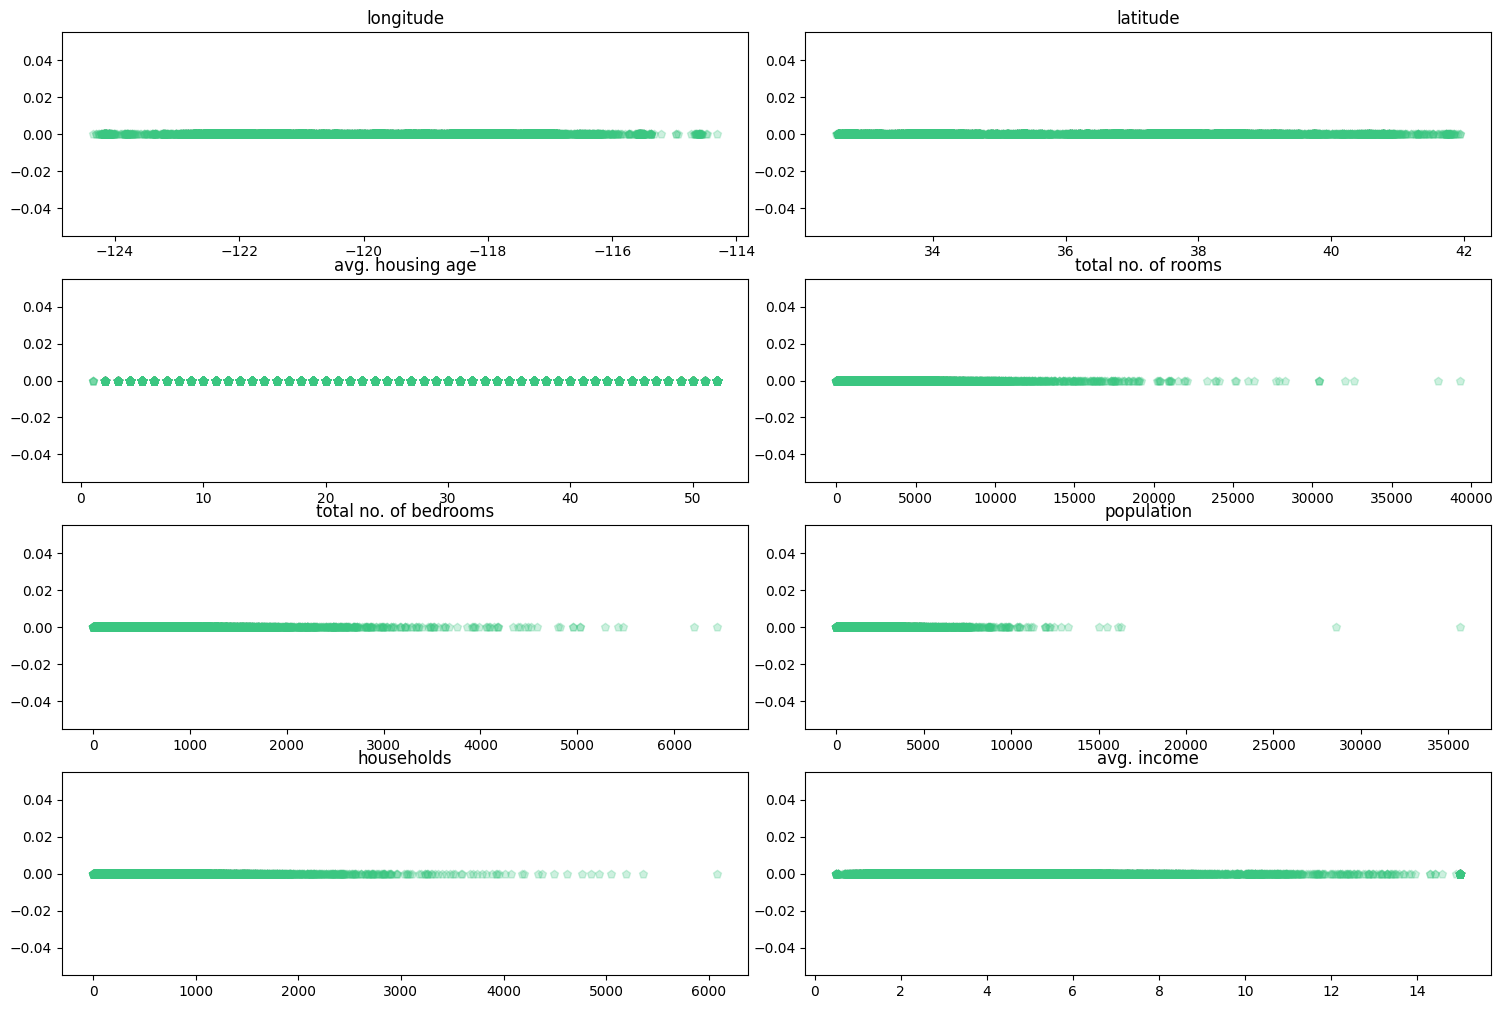

In [418]:
feature_names = ["longitude", "latitude", "avg. housing age", "total no. of rooms", "total no. of bedrooms", "population", "households", "avg. income"]
analyze(ch_X, feature_names=feature_names, color='#3BC681')

In [419]:
ch_X_trains, ch_X_cross, ch_Y_trains, ch_Y_cross = train_test_split(ch_X, ch_Y, test_size=0.3, random_state=0)

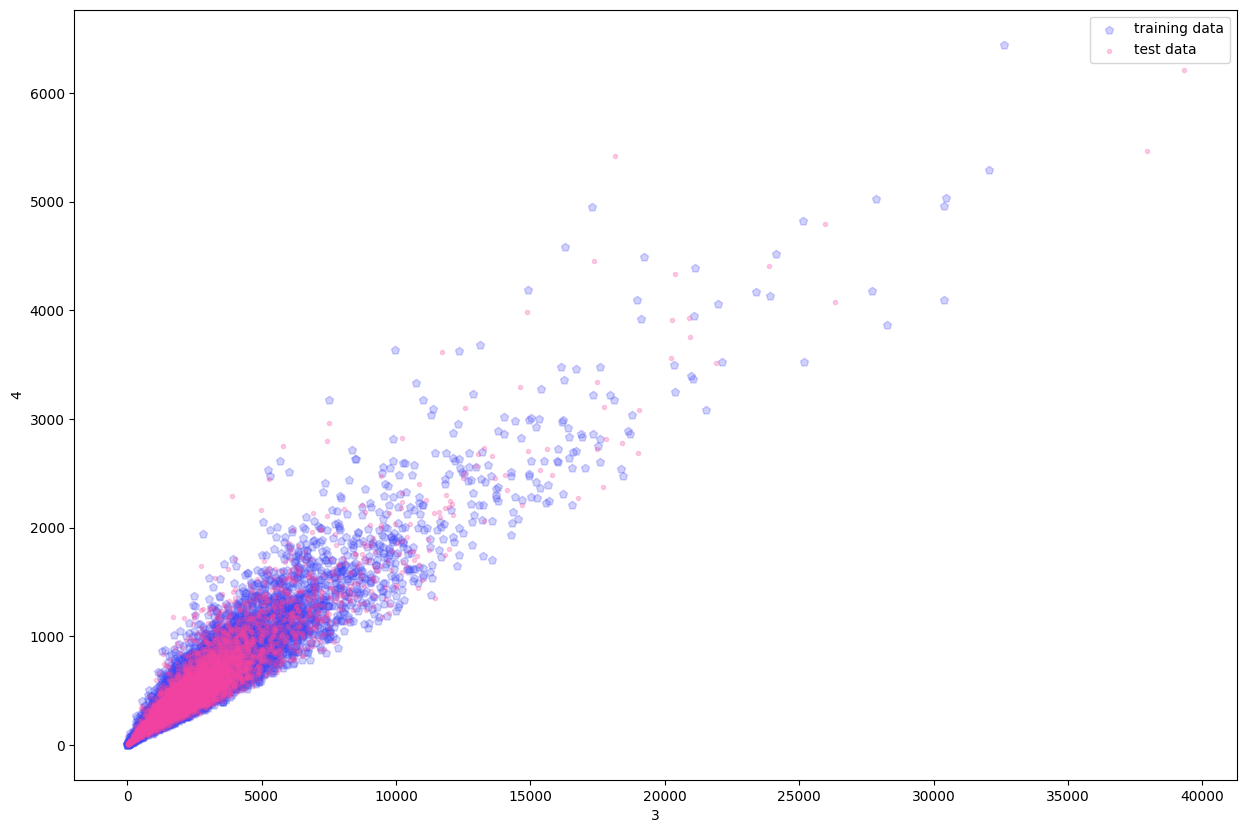

In [420]:
feature_2 = feature_names.index('total no. of bedrooms')
feature_1 = feature_names.index('total no. of rooms')
plot_train_cross_features(ch_X_trains, ch_X_cross, feature_1, feature_2)

In [421]:
ch_X_trains_normed, ch_X_cross_normed, ch_scaler = normalize_train_cross(ch_X_trains, ch_X_cross)

In [422]:
save_model(ch_scaler, './saved/misc/ch_scaler.pkl')

In [423]:
saved_ch_scaler = load_model('./saved/misc/ch_scaler.pkl')

In [424]:
ch_X_cross_normed

array([[0.72709163, 0.0042508 , 0.41176471, ..., 0.04338687, 0.06084526,
        0.2518517 ],
       [0.63545817, 0.1466525 , 0.60784314, ..., 0.0362398 , 0.07038316,
        0.36411222],
       [0.25      , 0.64930925, 0.54901961, ..., 0.04347095, 0.08765006,
        0.26543082],
       ...,
       [0.64143426, 0.1434644 , 0.56862745, ..., 0.0145744 , 0.03535603,
        0.50862057],
       [0.46912351, 0.4272051 , 0.64705882, ..., 0.01008997, 0.01578688,
        0.10799161],
       [0.23505976, 0.51222104, 0.60784314, ..., 0.02561731, 0.05410294,
        0.28800982]])

In [425]:
# if the sum is 1 and above then that means values of the normed
# cross dataset are not equal
np.sum((~(saved_ch_scaler.transform(ch_X_cross) == ch_X_cross_normed)).astype('int'))

0

## Laptop prices (both continous & discrete inputs and continuous outputs)
1. load
2. visualize raw
3. encode categorical features
4. visualize encoded categorical features
5. split
6. visualize split

In [426]:
with open('./data/laptop_price.csv', 'rb') as file:
  result = chardet.detect(file.read())
result['encoding']

'ISO-8859-1'

In [427]:
laptop_price = pd.read_csv('./data/laptop_price.csv', index_col=0, encoding='ISO-8859-1')

# laptop_price.columns != "Price_euros"
lp_X, lp_Y = laptop_price.loc[:, laptop_price.columns != 'Price_euros'], laptop_price['Price_euros']
lp_X.reset_index(drop=True, inplace=True)

In [428]:
lp_X

Company                              Product            TypeName  Inches  \
0      Apple                          MacBook Pro           Ultrabook   13.30   
1      Apple                          Macbook Air           Ultrabook   13.30   
2         HP                               250 G6            Notebook   15.60   
3      Apple                          MacBook Pro           Ultrabook   15.40   
4      Apple                          MacBook Pro           Ultrabook   13.30   
...      ...                                  ...                 ...     ...   
1298  Lenovo                       Yoga 500-14ISK  2 in 1 Convertible   14.00   
1299  Lenovo                       Yoga 900-13ISK  2 in 1 Convertible   13.30   
1300  Lenovo                   IdeaPad 100S-14IBR            Notebook   14.00   
1301      HP  15-AC110nv (i7-6500U/6GB/1TB/Radeon            Notebook   15.60   
1302    Asus  X553SA-XX031T (N3050/4GB/500GB/W10)            Notebook   15.60   

                                ScreenResolution  \
0             IPS Panel Retina Display 2560x1600   
1                                       1440x900   
2                              Full HD 1920x1080   
3             IPS Panel Retina Display 2880x1800   
4             IPS Panel Retina Display 2560x1600   
...                                          ...   
1298   IPS Panel Full HD / Touchscreen 1920x1080   
1299  IPS Panel Quad HD+ / Touchscreen 3200x1800   
1300                                    1366x768   
1301                                    1366x768   
1302                                    1366x768   

                                       Cpu   Ram               Memory  \
0                     Intel Core i5 2.3GHz   8GB            128GB SSD   
1                     Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
2               Intel Core i5 7200U 2.5GHz   8GB            256GB SSD   
3                     Intel Core i7 2.7GHz  16GB            512GB SSD   
4                     Intel Core i5 3.1GHz   8GB            256GB SSD   
...                                    ...   ...                  ...   
1298            Intel Core i7 6500U 2.5GHz   4GB            128GB SSD   
1299            Intel Core i7 6500U 2.5GHz  16GB            512GB SSD   
1300  Intel Celeron Dual Core N3050 1.6GHz   2GB   64GB Flash Storage   
1301            Intel Core i7 6500U 2.5GHz   6GB              1TB HDD   
1302  Intel Celeron Dual Core N3050 1.6GHz   4GB            500GB HDD   

                               Gpu       OpSys  Weight  
0     Intel Iris Plus Graphics 640       macOS  1.37kg  
1           Intel HD Graphics 6000       macOS  1.34kg  
2            Intel HD Graphics 620       No OS  1.86kg  
3               AMD Radeon Pro 455       macOS  1.83kg  
4     Intel Iris Plus Graphics 650       macOS  1.37kg  
...                            ...         ...     ...  
1298         Intel HD Graphics 520  Windows 10   1.8kg  
1299         Intel HD Graphics 520  Windows 10   1.3kg  
1300             Intel HD Graphics  Windows 10   1.5kg  
1301            AMD Radeon R5 M330  Windows 10  2.19kg  
1302             Intel HD Graphics  Windows 10   2.2kg  

[1303 rows x 11 columns]

In [429]:
cat_cols = get_cat_cols(lp_X)
cat_cols

['Gpu',
 'Memory',
 'Weight',
 'Company',
 'OpSys',
 'TypeName',
 'Ram',
 'Product',
 'Cpu',
 'ScreenResolution']

['#347804', '#D404AF', '#242E19', '#82916B', '#3A483B', '#36473C', '#84C13E', '#701AC0', '#FAE9FA', '#494097', '#E25F29', '#217561', '#4EB9A2', '#870FB1', '#18D98E', '#7BE6B9', '#D09494', '#B1E291', '#3EF9C8', '#FCAA6D', '#3DD0FA', '#5A56F5', '#3C3E4C', '#56D198', '#E3D442', '#6B2DBB', '#F4BDF9', '#C8EB7A', '#9CD322', '#AE0C3C', '#F1E4E1', '#37D431', '#702404', '#600715', '#AEDA0E', '#E35C25', '#9CE17E', '#7A2C76', '#89C8DD', '#FB6682', '#7B2EBA', '#66D39B', '#298358', '#740170', '#3E8E3F', '#3B7375', '#B9C173', '#136D5C', '#4FDF27', '#E96DC4', '#9A6AED', '#C54C0D', '#0E3C22', '#A64E46', '#A4FB20', '#AA3D56', '#6F0C76', '#C4B458', '#376FE4', '#9E4E0D', '#E63A8F', '#F24626', '#E0DA77', '#63E8AC', '#CF47AD', '#ECFDA2', '#24734E', '#261A89', '#477A6C', '#D3969C', '#73AB10', '#D6417C', '#7F1B60', '#395D73', '#4869A2', '#BAA465', '#F38D3A', '#16062B', '#F8B0B3', '#5E61C9', '#608B4B', '#E268E8', '#25F5E8', '#AD6127', '#8DA802', '#DB4901', '#C68617', '#0B1C2B', '#6849A7', '#0C4AC9', '#95386D'

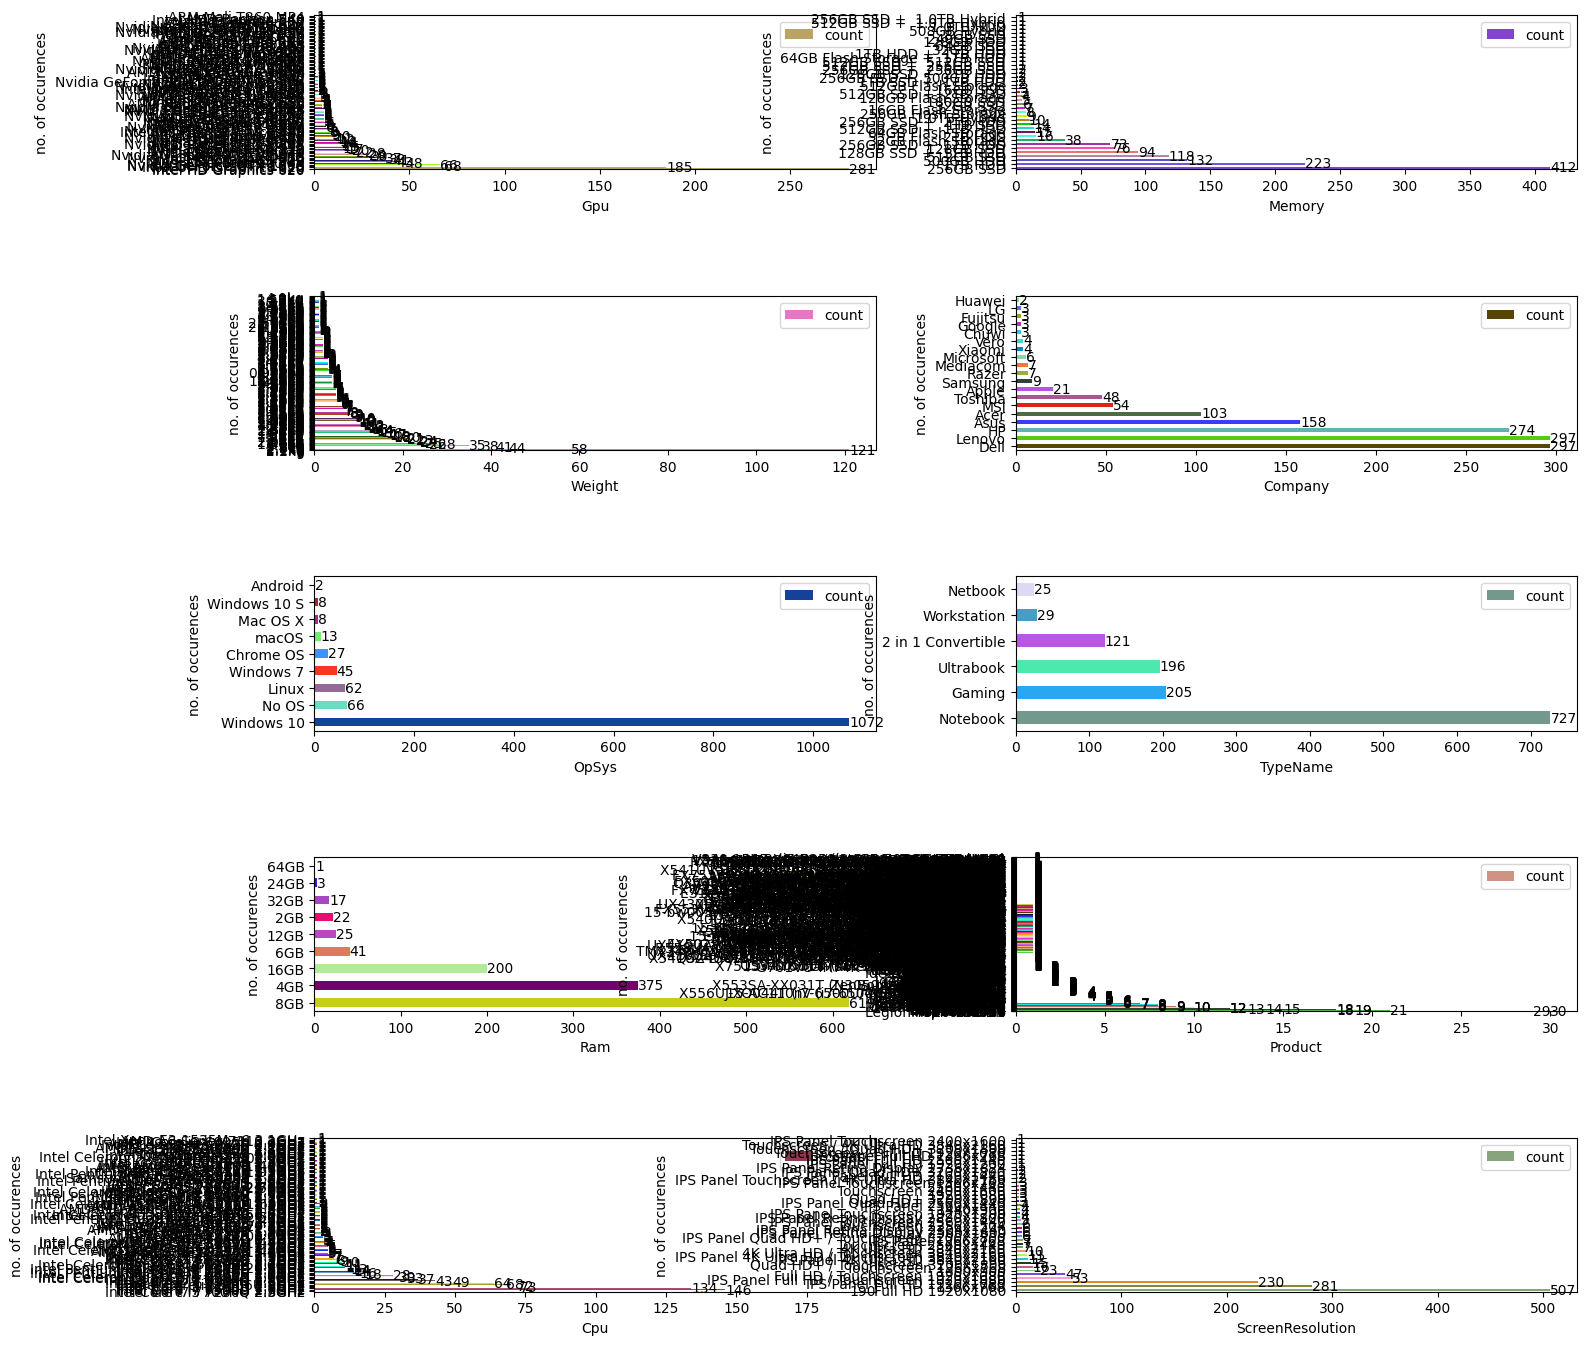

In [430]:
disp_cat_feat(lp_X, cat_cols, fig_dims=(len(cat_cols) // 2, 2))

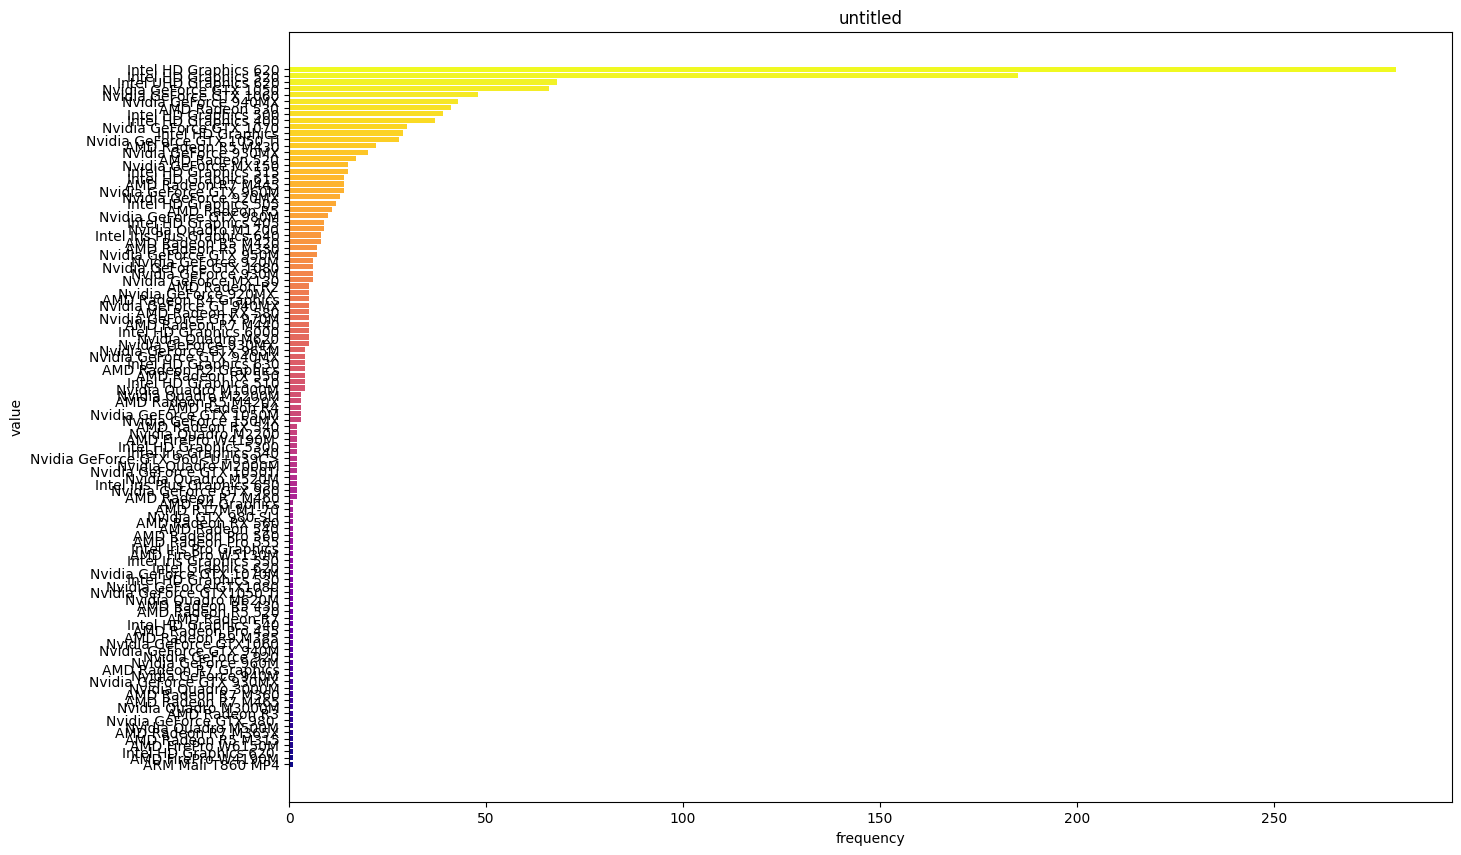

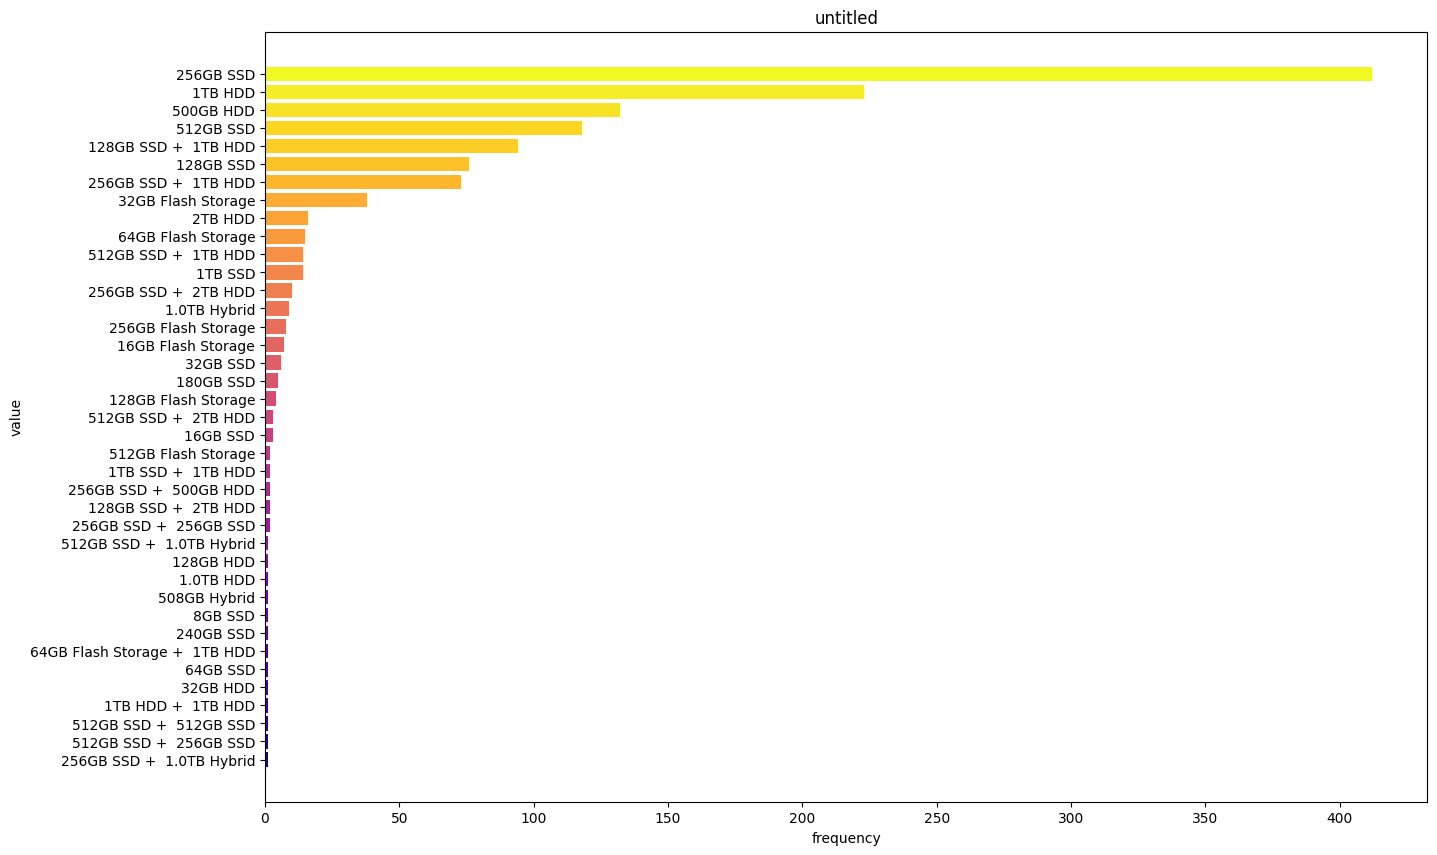

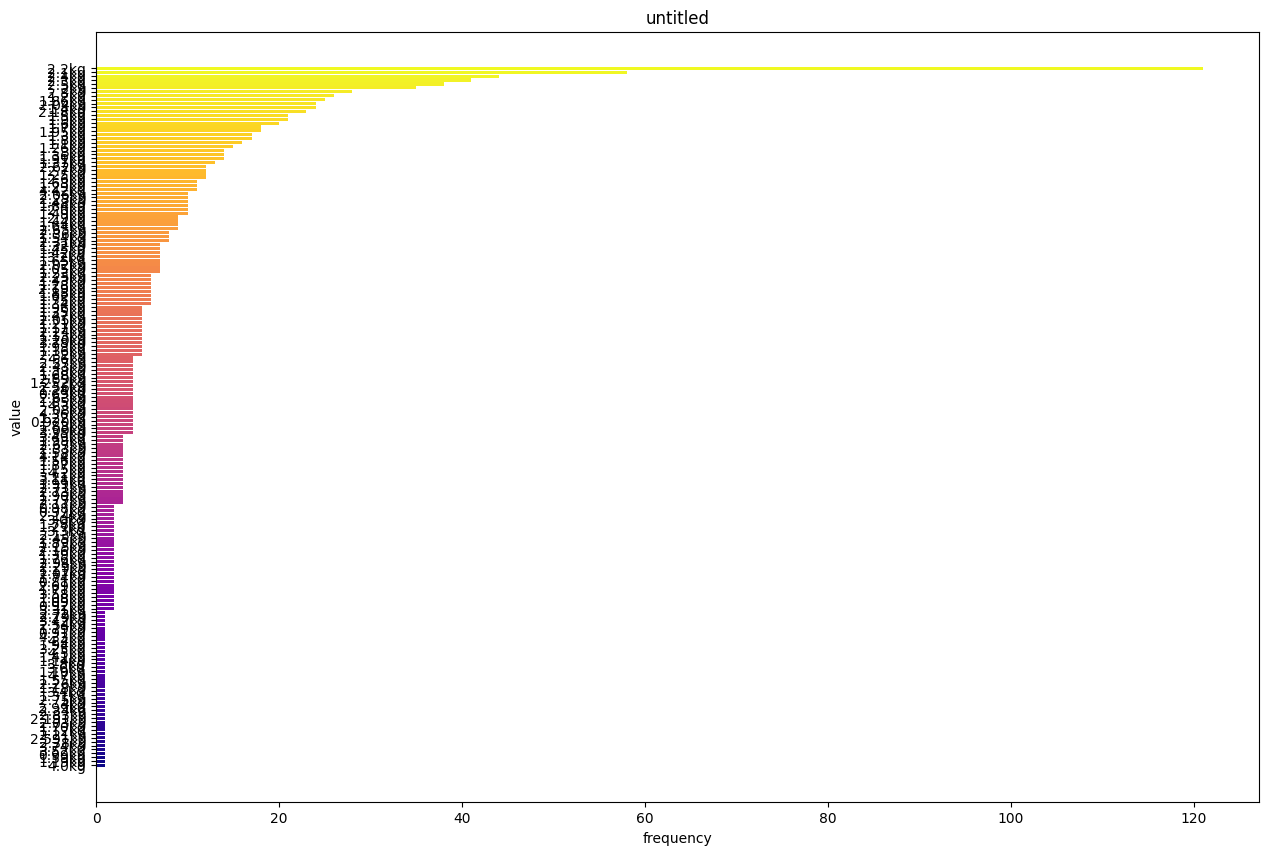

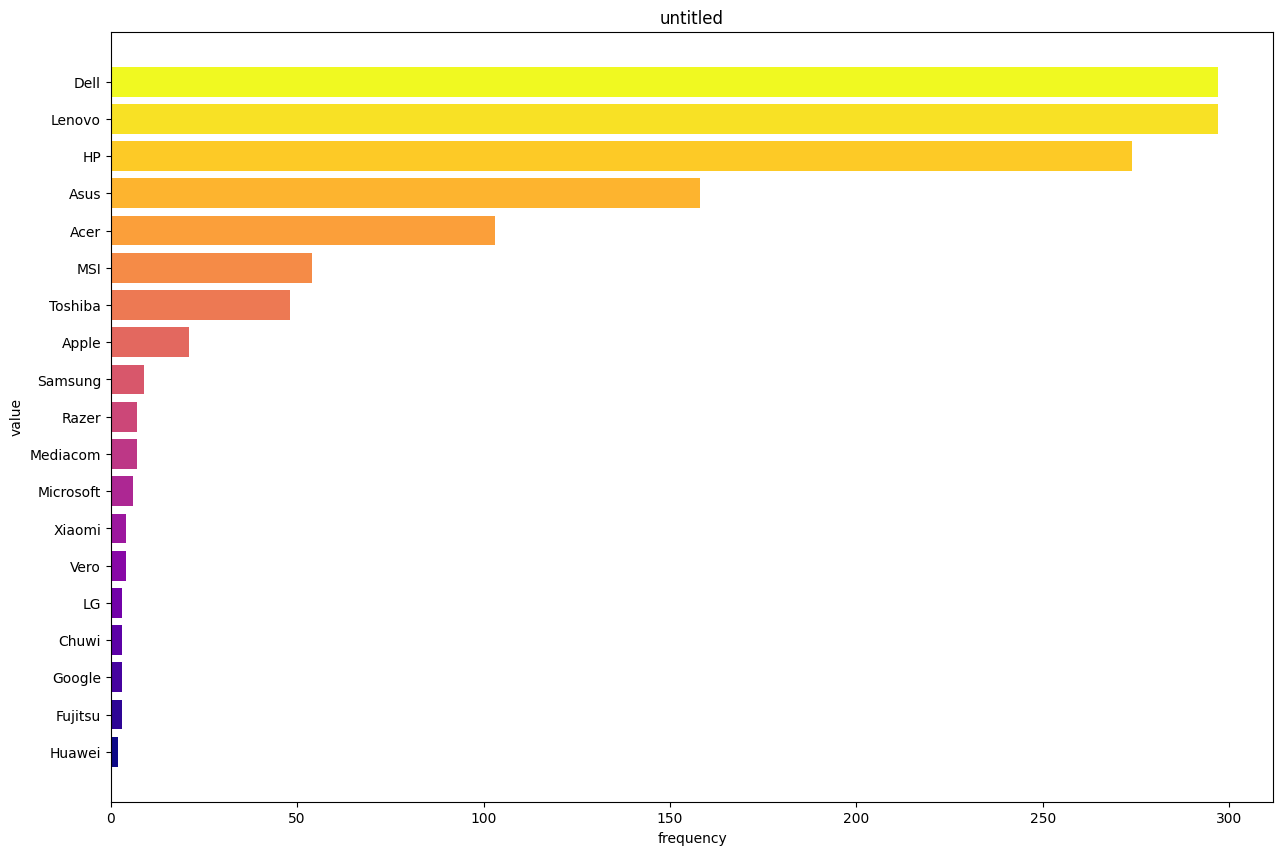

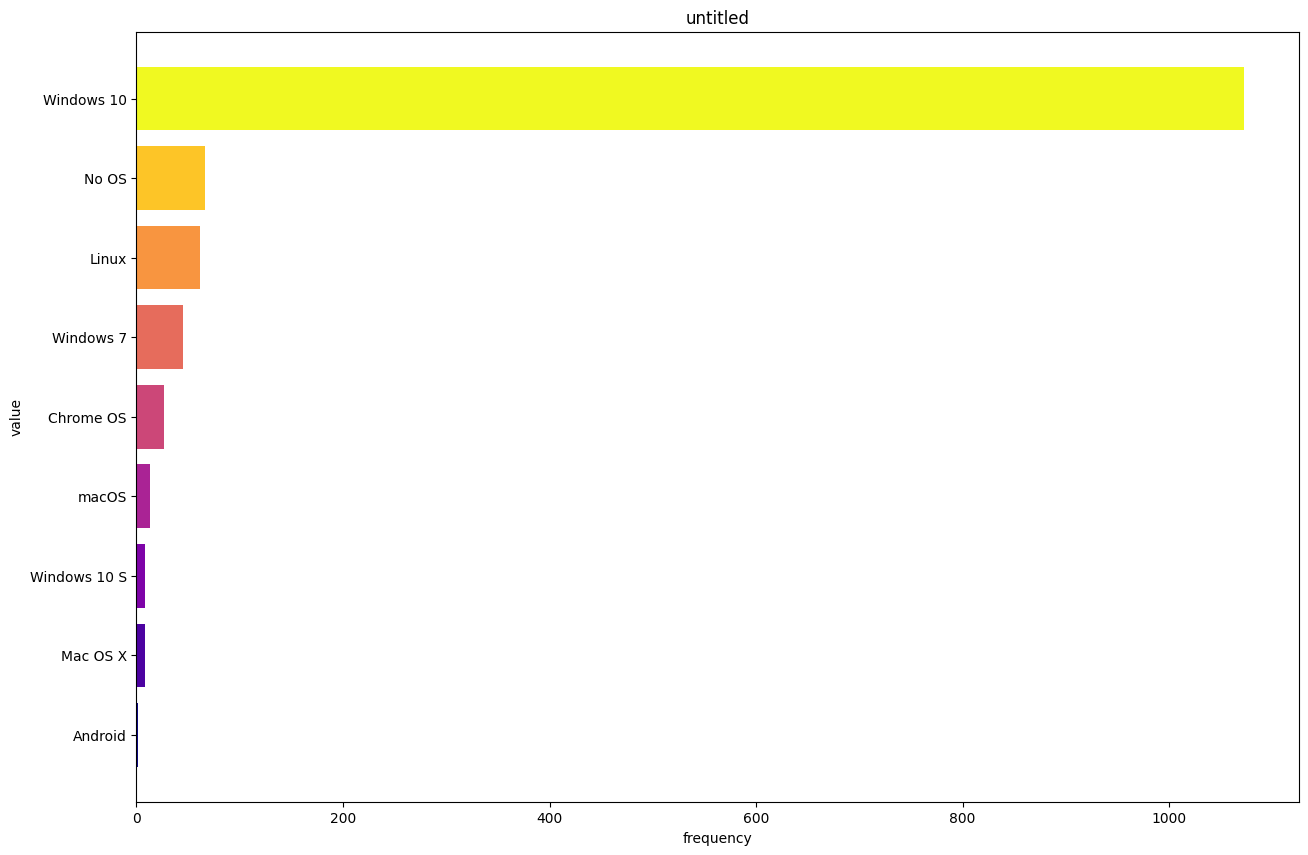

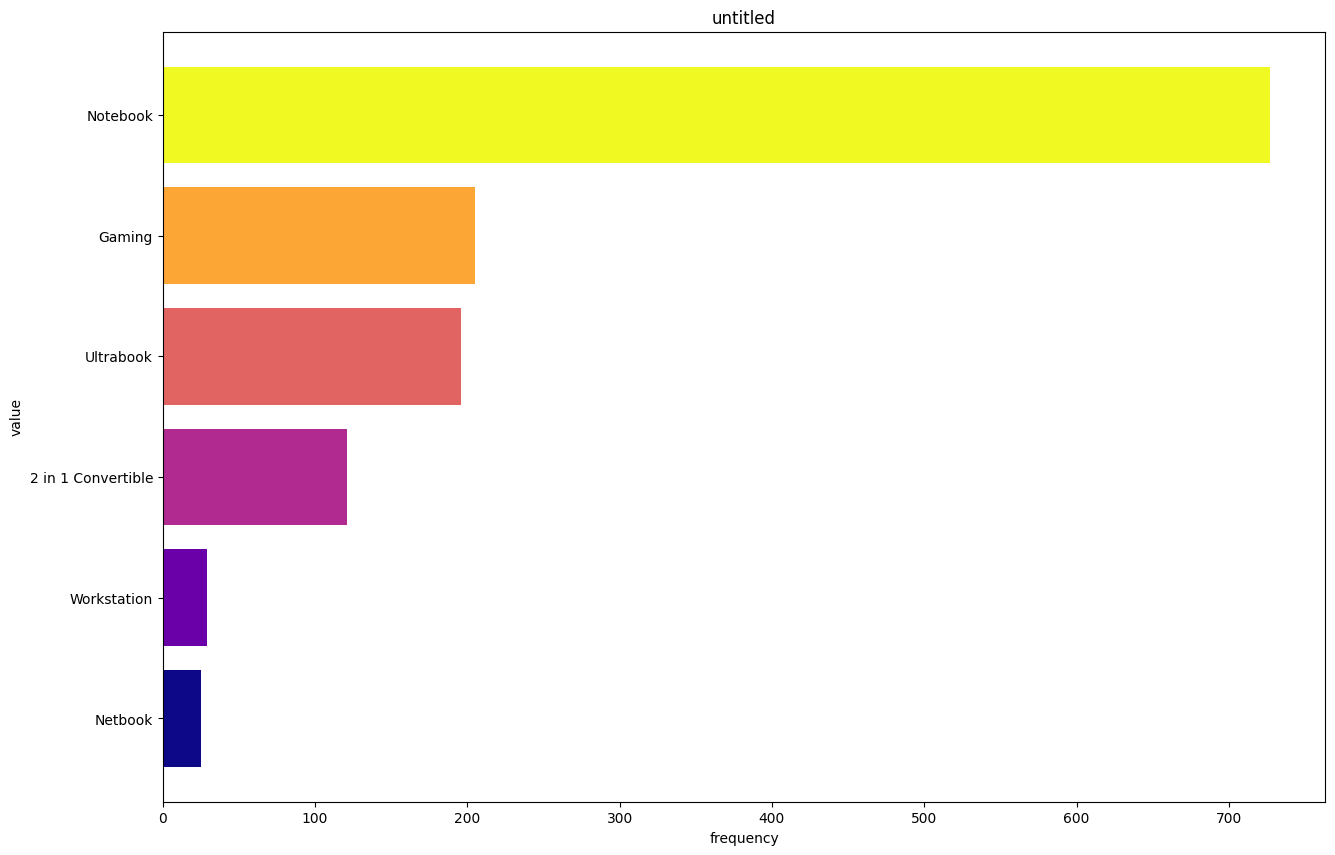

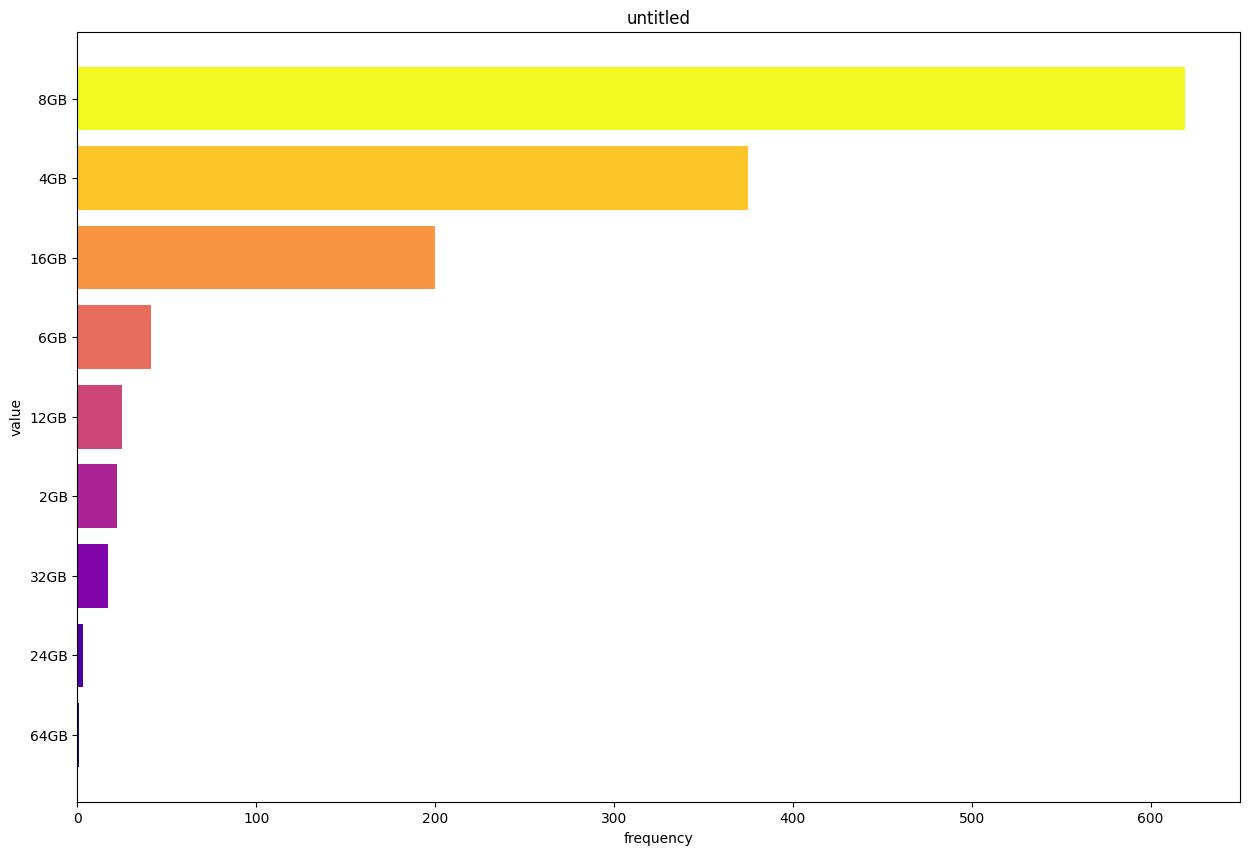

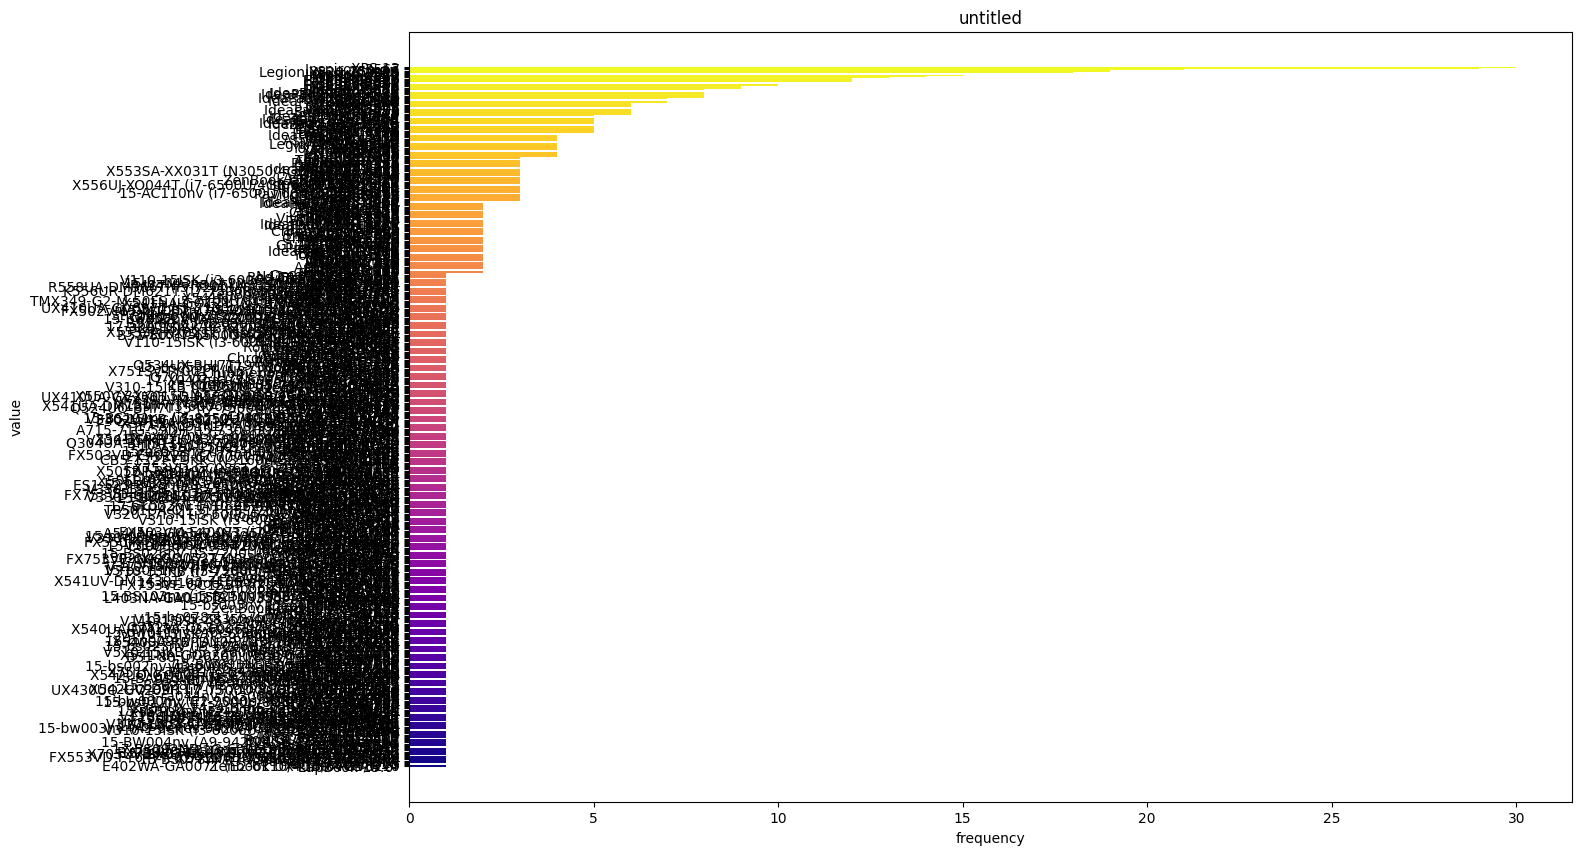

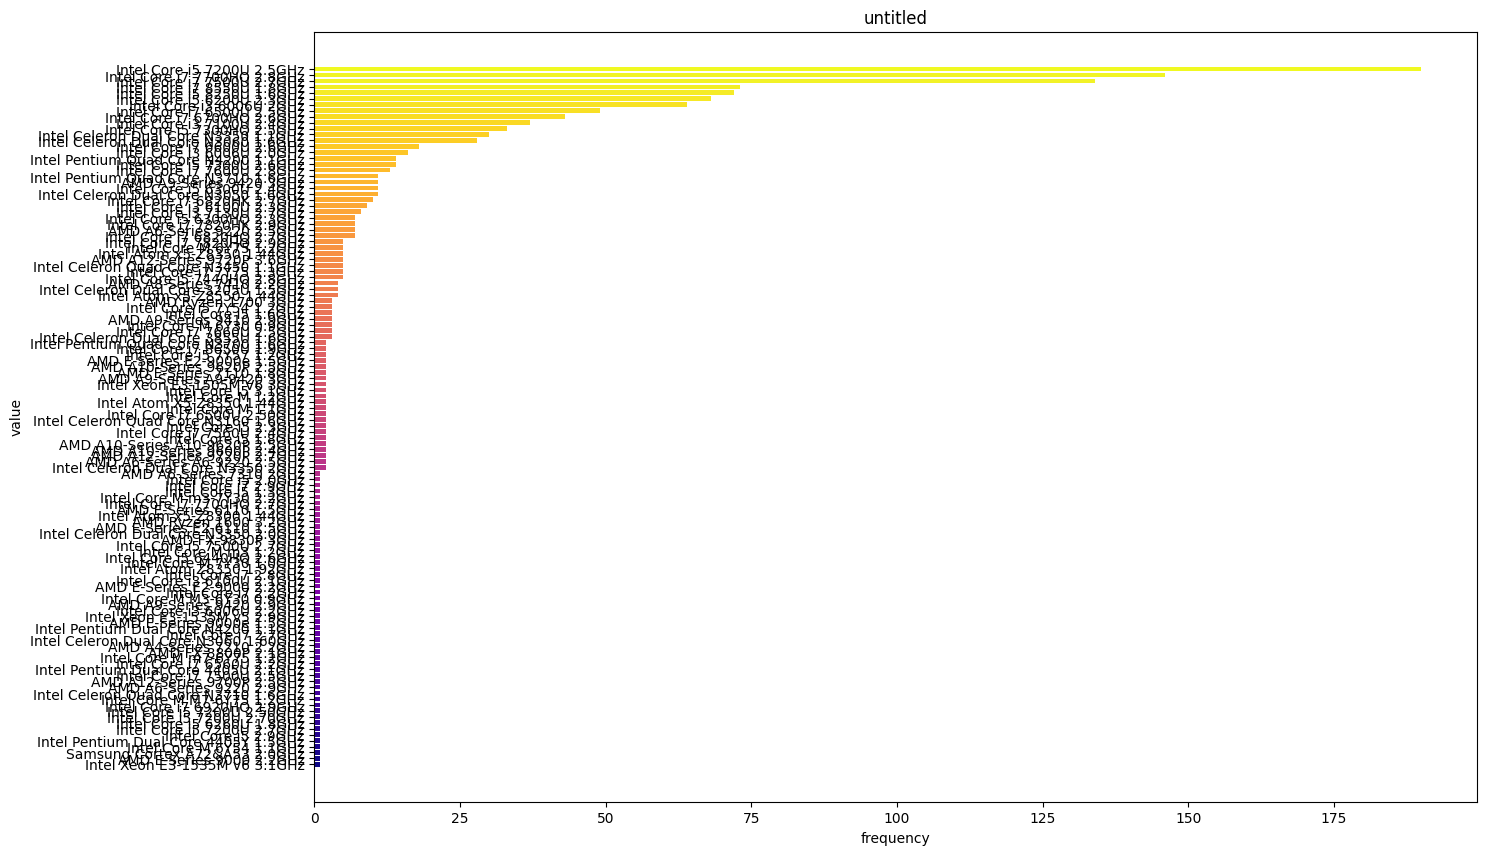

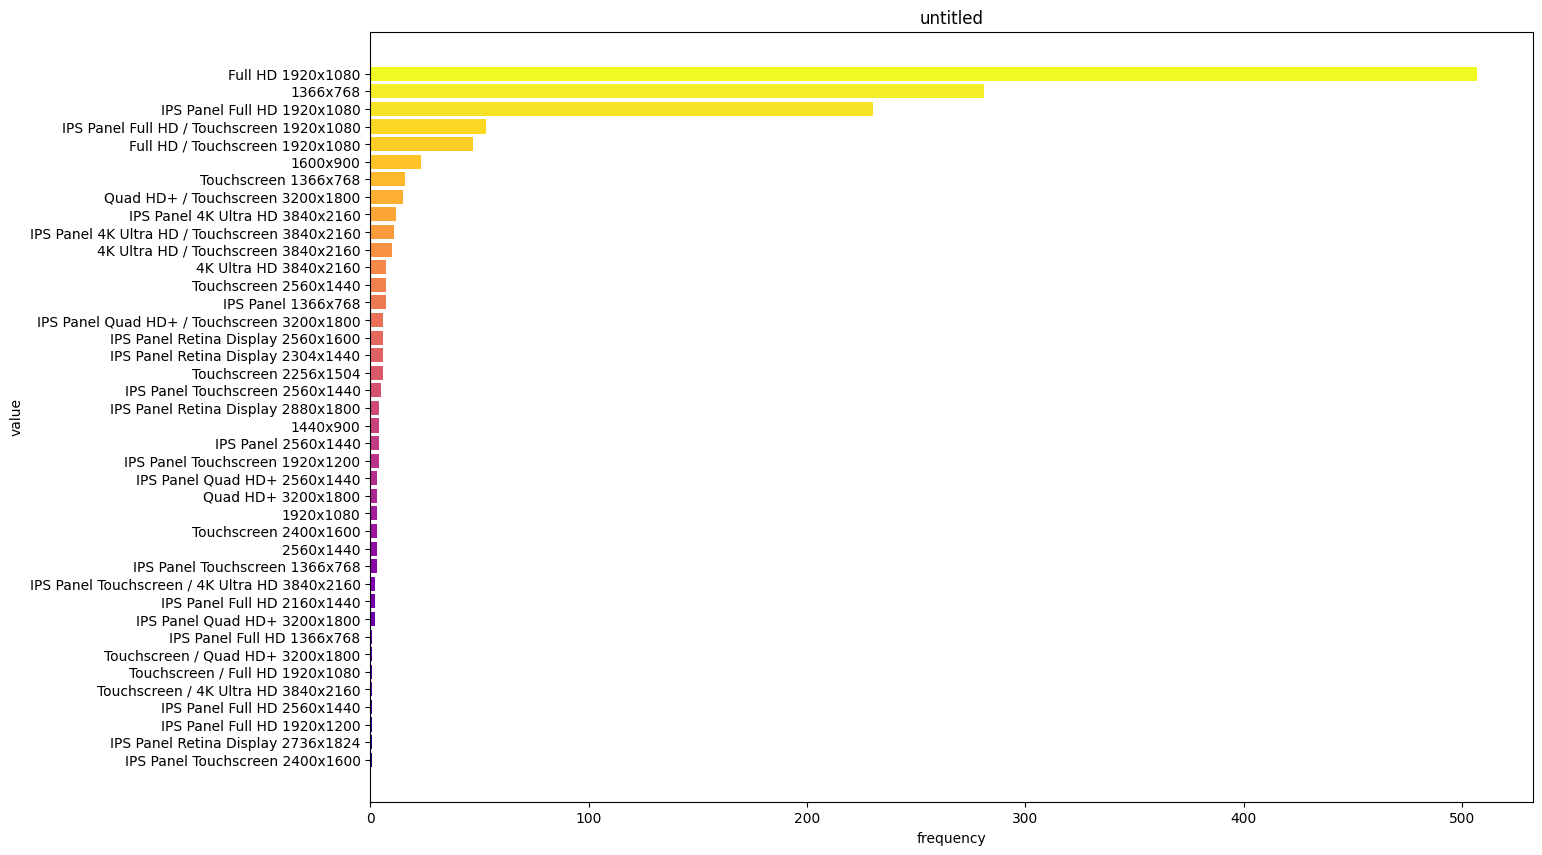

In [431]:
for cat_col in cat_cols:
    view_value_frequency(lp_X[cat_col].value_counts(), limit=lp_X[cat_col].unique().size)

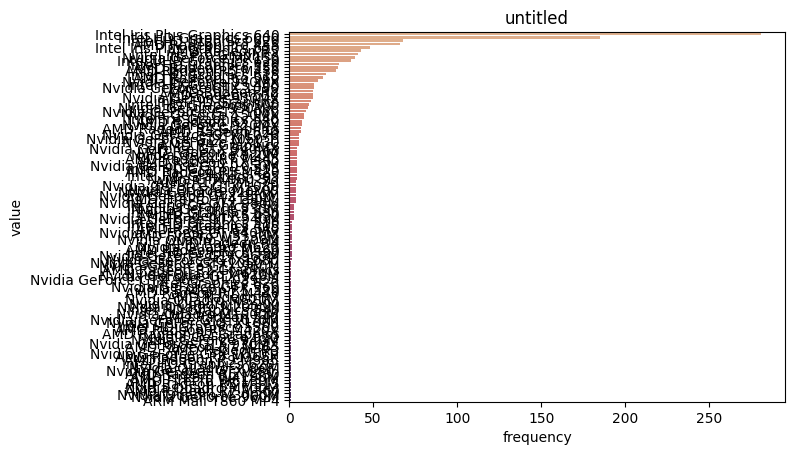

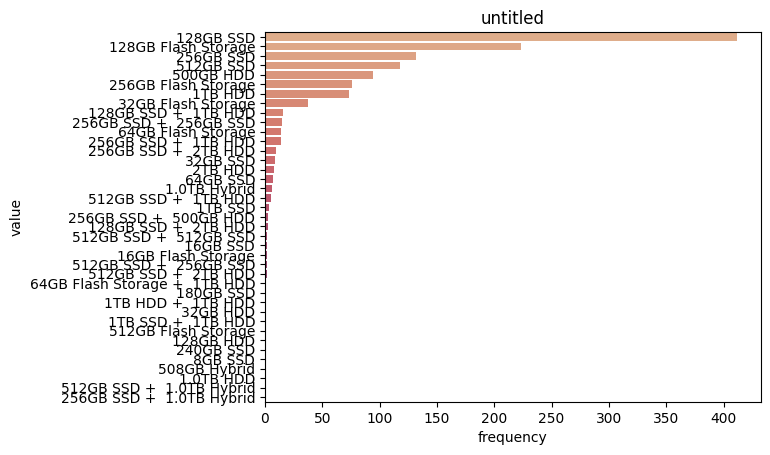

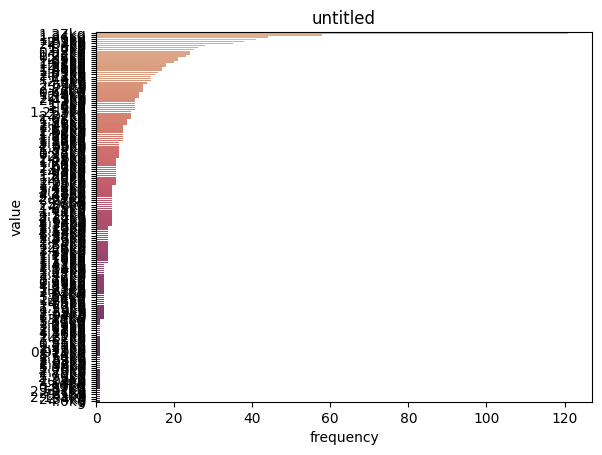

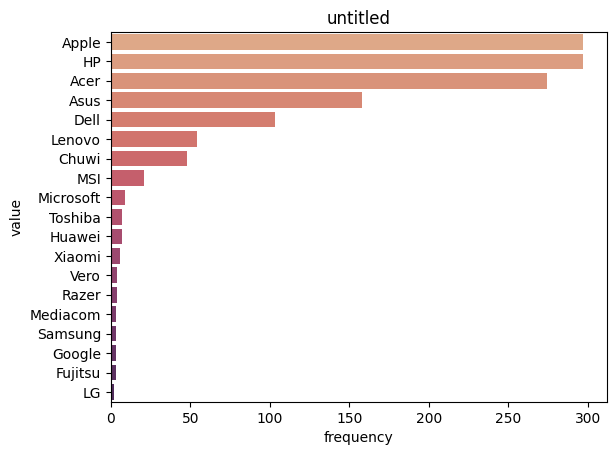

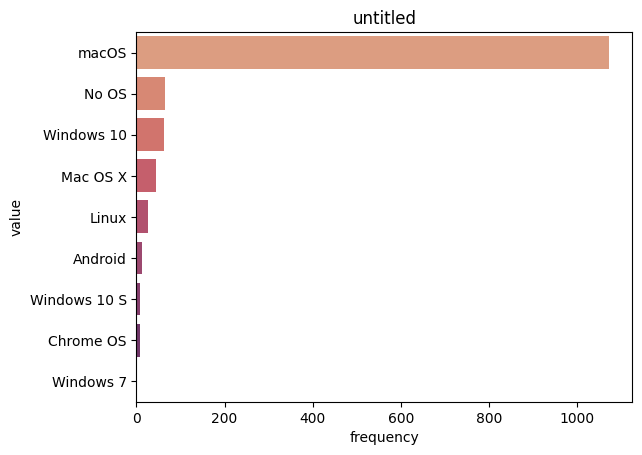

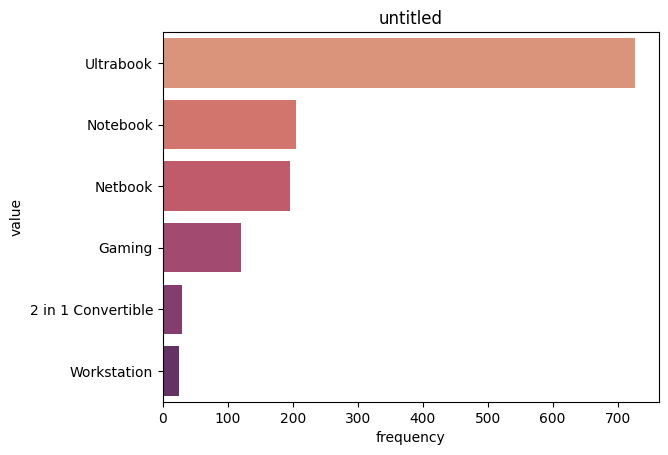

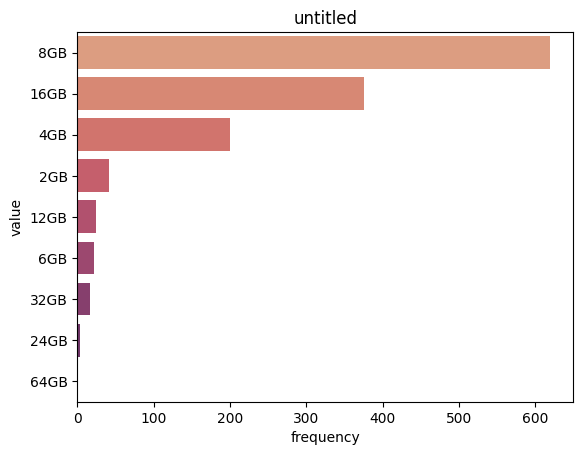

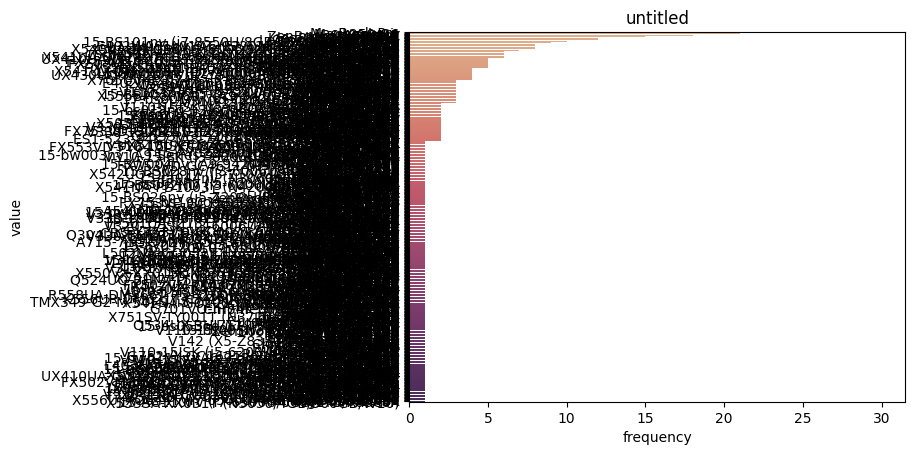

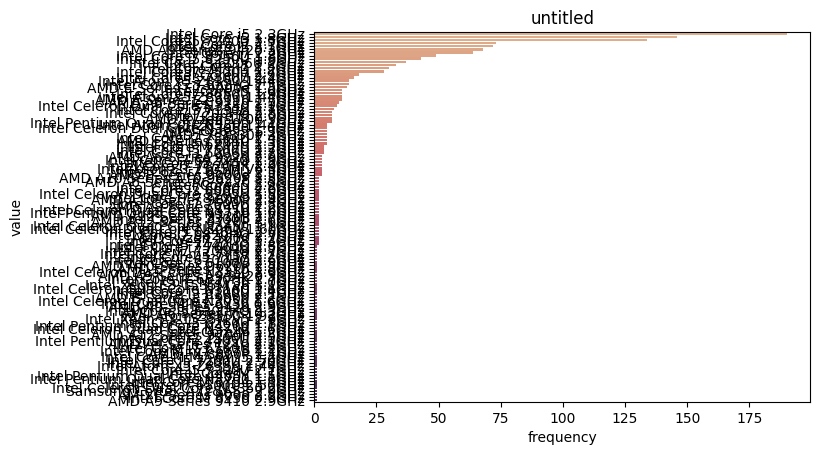

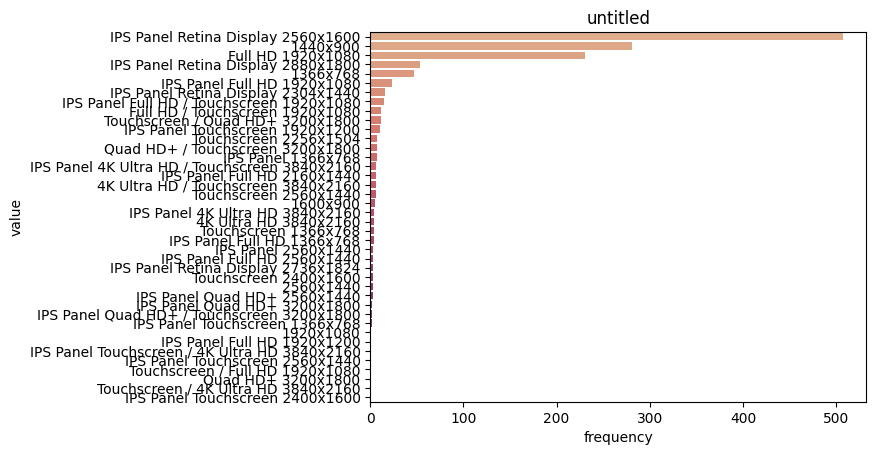

In [432]:
for cat_col in cat_cols:
    view_label_freq(lp_X[cat_col].value_counts(), labels=lp_X[cat_col].unique(), horizontal=True)

In [433]:
lp_X_encoded, lp_oe = encode_features(lp_X[cat_cols])
lp_X_encoded

array([[ 58,   4,  38, ..., 300,  65,  23],
       [ 51,   2,  35, ..., 301,  63,   1],
       [ 53,  16,  74, ...,  50,  74,   8],
       ...,
       [ 40,  35,  56, ..., 196,  34,   0],
       [ 21,  10, 104, ...,   2,  89,   0],
       [ 40,  26, 113, ..., 568,  34,   0]], dtype=int64)

In [434]:
save_model(lp_oe, './saved/misc/lp_oe.pkl')

In [435]:
saved_lp_oe = load_model('./saved/misc/lp_oe.pkl')

In [436]:
# again if the sum is 1 and above then that means values of
# the normed cross dataset are not equal
np.sum((~(saved_lp_oe.transform(lp_X[cat_cols]) == lp_X_encoded)).astype('int'))

0

In [437]:
lp_X['Ram'].unique()

array(['8GB', '16GB', '4GB', '2GB', '12GB', '6GB', '32GB', '24GB', '64GB'],
      dtype=object)

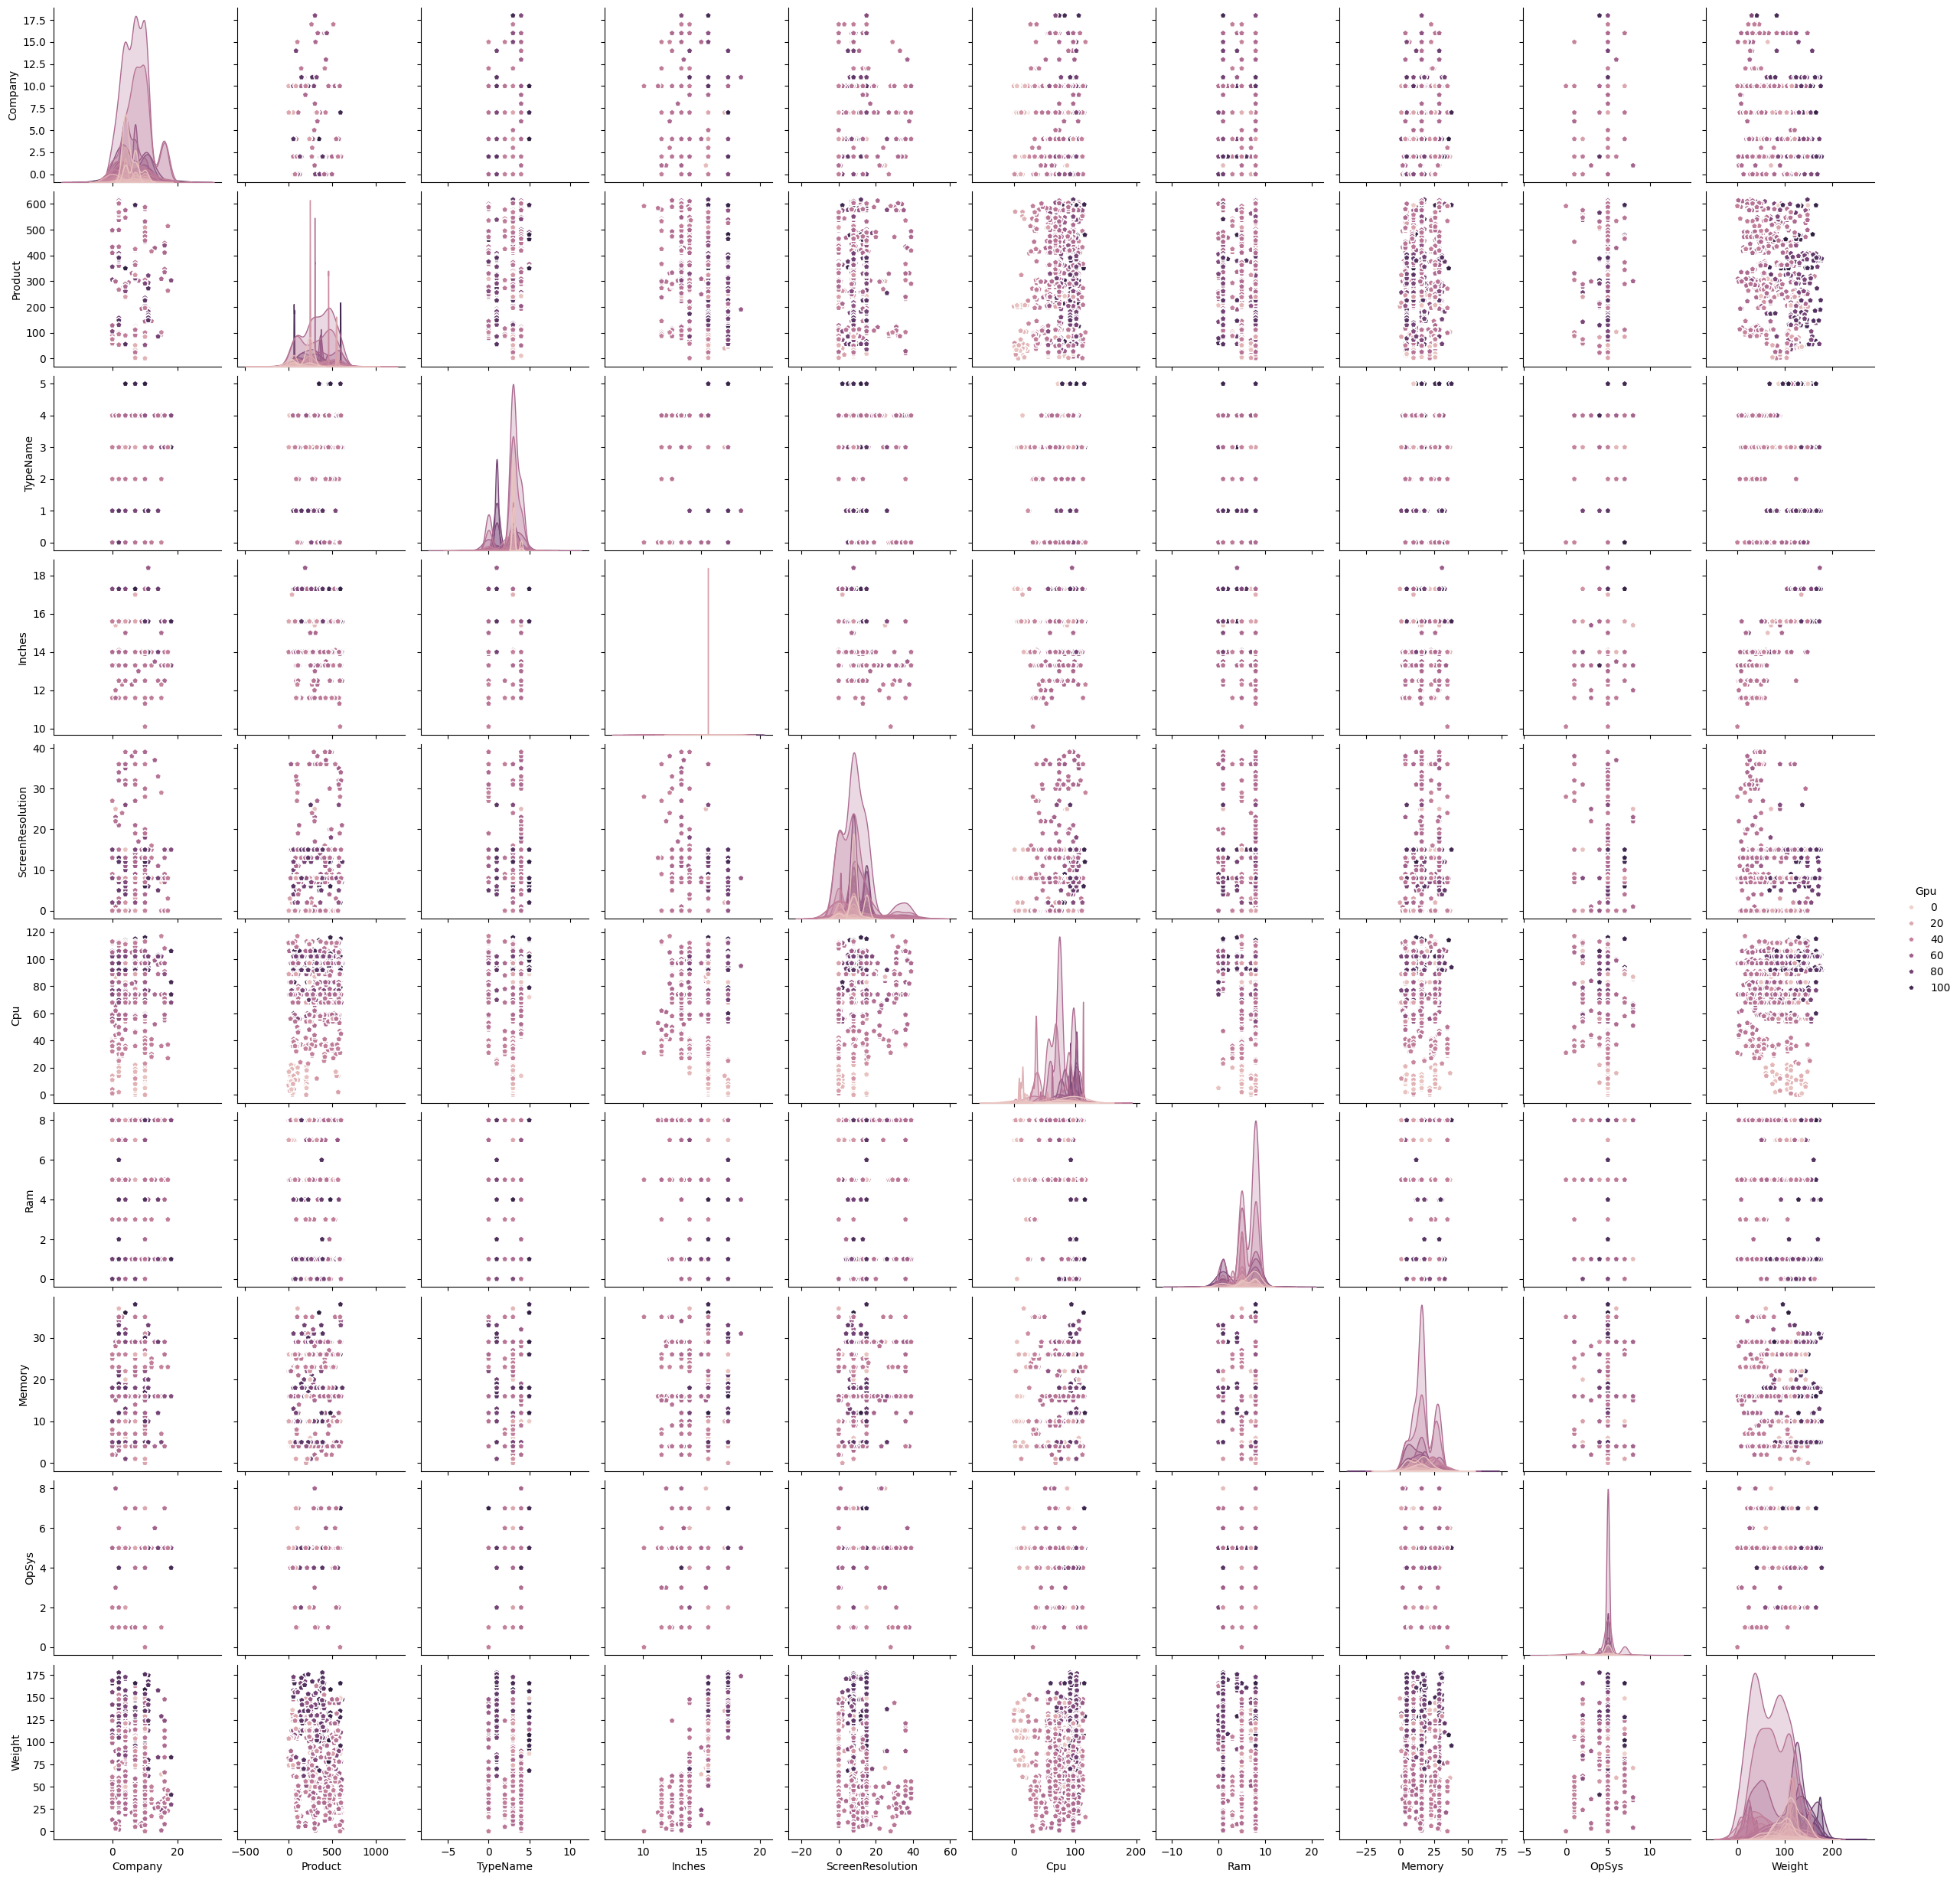

In [438]:
lp_X[cat_cols] = lp_X_encoded
sb.set_palette('mako')
sb.pairplot(lp_X, hue="Gpu", plot_kws={'marker': 'p', 'linewidth': 1})

In [439]:
lp_X_trains, lp_X_cross, lp_Y_trains, lp_Y_cross = train_test_split(lp_X, lp_Y, test_size=0.3, random_state=0)

In [440]:
lp_X_cross

Company  Product  TypeName  Inches  ScreenResolution  Cpu  Ram  Memory  \
580        12      415         3   14.00                15   41    5      25   
1017       10      464         3   17.30                12   94    1      29   
761         4      283         4   12.50                 8   99    1      16   
686         7       50         3   15.60                 0   74    5      26   
186         4      577         3   15.60                 5  102    1      29   
...       ...      ...       ...     ...               ...  ...  ...     ...   
520        10      292         1   15.60                15  102    8      18   
733         0      128         3   15.60                 0   74    5      26   
936         4      547         3   15.60                 0   54    5      10   
500         2      534         2   11.60                 0   37    5      35   
877        18      303         4   13.30                15   68    8      16   

      Gpu  OpSys  Weight  
580    43      5      46  
1017   99      7     124  
761    53      5      19  
686     6      5      74  
186    75      5      92  
...   ...    ...     ...  
520    79      5     153  
733    53      5     124  
936    47      5     102  
500    43      6      32  
877    72      5      30  

[391 rows x 11 columns]

In [441]:
lp_X_cross_decoded = saved_lp_oe.inverse_transform(lp_X_cross[cat_cols])
lp_X_cross_decoded

array([['Intel HD Graphics 500', '32GB SSD', '1.45kg', ...,
        'SmartBook Edge', 'Intel Celeron Quad Core N3450 1.1GHz',
        'IPS Panel Full HD 1920x1080'],
       ['Nvidia Quadro 3000M', '512GB SSD', '2.4kg', ..., 'ThinkPad P70',
        'Intel Core i7 6820HQ 2.7GHz', 'IPS Panel 4K Ultra HD 3840x2160'],
       ['Intel HD Graphics 620', '256GB SSD', '1.18kg', ...,
        'Latitude 7280', 'Intel Core i7 7600U 2.8GHz',
        'Full HD 1920x1080'],
       ...,
       ['Intel HD Graphics 520', '1TB HDD', '2.18kg', ..., 'Vostro 3568',
        'Intel Core i3 6006U 2.0GHz', '1366x768'],
       ['Intel HD Graphics 500', '64GB Flash Storage', '1.2kg', ...,
        'VivoBook E201NA', 'Intel Celeron Dual Core N3350 1.1GHz',
        '1366x768'],
       ['Nvidia GeForce 940MX', '256GB SSD', '1.28kg', ...,
        'Mi Notebook', 'Intel Core i5 6200U 2.3GHz',
        'IPS Panel Full HD 1920x1080']], dtype=object)

In [442]:
lp_X_cross_decoded.shape

(391, 10)

In [443]:
# shows all the unique values/categories in each feature/variable/column
saved_lp_oe.categories_

[array(['AMD FirePro W4190M', 'AMD FirePro W4190M ', 'AMD FirePro W5130M',
        'AMD FirePro W6150M', 'AMD R17M-M1-70', 'AMD R4 Graphics',
        'AMD Radeon 520', 'AMD Radeon 530', 'AMD Radeon 540',
        'AMD Radeon Pro 455', 'AMD Radeon Pro 555', 'AMD Radeon Pro 560',
        'AMD Radeon R2', 'AMD Radeon R2 Graphics', 'AMD Radeon R3',
        'AMD Radeon R4', 'AMD Radeon R4 Graphics', 'AMD Radeon R5',
        'AMD Radeon R5 430', 'AMD Radeon R5 520', 'AMD Radeon R5 M315',
        'AMD Radeon R5 M330', 'AMD Radeon R5 M420', 'AMD Radeon R5 M420X',
        'AMD Radeon R5 M430', 'AMD Radeon R7', 'AMD Radeon R7 Graphics',
        'AMD Radeon R7 M360', 'AMD Radeon R7 M365X', 'AMD Radeon R7 M440',
        'AMD Radeon R7 M445', 'AMD Radeon R7 M460', 'AMD Radeon R7 M465',
        'AMD Radeon R9 M385', 'AMD Radeon RX 540', 'AMD Radeon RX 550',
        'AMD Radeon RX 560', 'AMD Radeon RX 580', 'ARM Mali T860 MP4',
        'Intel Graphics 620', 'Intel HD Graphics', 'Intel HD Graphics 400'

## Breast cancer diagnosis (all continuous inputs and discrete outputs)
1. load
2. visualize raw
3. encode categorical target
4. split
5. visualize split
6. normalize
7. visualize normalization

In [444]:
# use path below if in local machine
breast_cancer = pd.read_csv('./data/data.csv')
bc_X, bc_Y = breast_cancer.drop(['id', 'Unnamed: 32', 'diagnosis'], axis=1, inplace=False), breast_cancer['diagnosis']
bc_X

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0          17.99         10.38          122.80    1001.00             0.12   
1          20.57         17.77          132.90    1326.00             0.08   
2          19.69         21.25          130.00    1203.00             0.11   
3          11.42         20.38           77.58     386.10             0.14   
4          20.29         14.34          135.10    1297.00             0.10   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00    1479.00             0.11   
565        20.13         28.25          131.20    1261.00             0.10   
566        16.60         28.08          108.30     858.10             0.08   
567        20.60         29.33          140.10    1265.00             0.12   
568         7.76         24.54           47.92     181.00             0.05   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0                0.28            0.30                 0.15           0.24   
1                0.08            0.09                 0.07           0.18   
2                0.16            0.20                 0.13           0.21   
3                0.28            0.24                 0.11           0.26   
4                0.13            0.20                 0.10           0.18   
..                ...             ...                  ...            ...   
564              0.12            0.24                 0.14           0.17   
565              0.10            0.14                 0.10           0.18   
566              0.10            0.09                 0.05           0.16   
567              0.28            0.35                 0.15           0.24   
568              0.04            0.00                 0.00           0.16   

     fractal_dimension_mean  ...  radius_worst  texture_worst  \
0                      0.08  ...         25.38          17.33   
1                      0.06  ...         24.99          23.41   
2                      0.06  ...         23.57          25.53   
3                      0.10  ...         14.91          26.50   
4                      0.06  ...         22.54          16.67   
..                      ...  ...           ...            ...   
564                    0.06  ...         25.45          26.40   
565                    0.06  ...         23.69          38.25   
566                    0.06  ...         18.98          34.12   
567                    0.07  ...         25.74          39.42   
568                    0.06  ...          9.46          30.37   

     perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0             184.60     2019.00              0.16               0.67   
1             158.80     1956.00              0.12               0.19   
2             152.50     1709.00              0.14               0.42   
3              98.87      567.70              0.21               0.87   
4             152.20     1575.00              0.14               0.20   
..               ...         ...               ...                ...   
564           166.10     2027.00              0.14               0.21   
565           155.00     1731.00              0.12               0.19   
566           126.70     1124.00              0.11               0.31   
567           184.60     1821.00              0.17               0.87   
568            59.16      268.60              0.09               0.06   

     concavity_worst  concave points_worst  symmetry_worst  \
0               0.71                  0.27            0.46   
1               0.24                  0.19            0.28   
2               0.45                  0.24            0.36   
3               0.69                  0.26            0.66   
4               0.40                  0.16            0.24   
..               ...                   ...             ...   
564             0.41                  0.22         

In [445]:
bc_Y

0      M
1      M
2      M
3      M
4      M
      ..
564    M
565    M
566    M
567    M
568    B
Name: diagnosis, Length: 569, dtype: object

In [446]:
get_cat_cols(bc_X)

[]

In [447]:
# note that 1 is now the malignant class 
# and 0 is the benign class/category
bc_Y_encoded, bc_Y_le =  encode_features(bc_Y)
bc_Y_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [448]:
# save label encoder for breast cancer dataset
save_model(bc_Y_le, './saved/misc/bc_Y_le.pkl')

In [449]:
saved_bc_Y_le = load_model('./saved/misc/bc_Y_le.pkl')

In [450]:
bc_X_trains, bc_X_cross, bc_Y_trains, bc_Y_cross = train_test_split(bc_X, bc_Y_encoded, test_size=0.3, random_state=0)

In [451]:
bc_X_trains_normed, bc_X_cross_normed, bc_scaler = normalize_train_cross(bc_X_trains, bc_X_cross)
bc_X_trains_normed

array([[0.21340338, 0.20248963, 0.20869325, ..., 0.25597658, 0.2712399 ,
        0.24111242],
       [0.16607506, 0.36929461, 0.15942229, ..., 0.22487082, 0.12773507,
        0.1533517 ],
       [0.2493729 , 0.34149378, 0.23826964, ..., 0.28284533, 0.30514488,
        0.17237308],
       ...,
       [0.11619102, 0.35726141, 0.11077327, ..., 0.17402687, 0.17524147,
        0.17263545],
       [0.12963226, 0.35311203, 0.11706171, ..., 0.        , 0.06780997,
        0.06919848],
       [0.21434995, 0.59004149, 0.21235575, ..., 0.33251808, 0.10782574,
        0.21172767]])

In [452]:
# save normalier for breast cancer dataset
save_model(bc_scaler, './saved/misc/bc_scaler.pkl')

In [453]:
saved_bc_scaler = load_model('./saved/misc/bc_scaler.pkl')

# Modelling

## Regression

### Ensemble Modelling

In [454]:
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR

In [455]:
reg_a = LazyRegressor(
    verbose=0, 
    ignore_warnings=True, 
    custom_metric=None, 
    regressors=[LinearRegression, Ridge, Lasso, DecisionTreeRegressor, RandomForestRegressor, XGBRegressor, SVR])
reg_models_train_a, reg_preds_train_a = reg_a.fit(ch_X_trains_normed, ch_X_trains_normed, ch_Y_trains, ch_Y_trains)
reg_models_cross_a, reg_preds_cross_a = reg_a.fit(ch_X_trains_normed, ch_X_cross_normed, ch_Y_trains, ch_Y_cross)

100%|██████████| 7/7 [01:07<00:00,  9.62s/it]


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 7/7 [00:54<00:00,  7.80s/it]


#### Here the output of the clf.fit() method that fits multiple different models is actually a dataframe containing all the multiple different models we have trained and their respective metric values like Adjusted R-squared, R-squared, RMSE, etc. that we can always access easily through indexing.

In [456]:
reg_models_train_a

Adjusted R-Squared  R-Squared      RMSE  Time Taken
Model                                                                     
DecisionTreeRegressor                1.00       1.00      0.00        0.42
RandomForestRegressor                0.97       0.97  18448.73       32.48
XGBRegressor                         0.94       0.94  27923.76        0.28
LinearRegression                     0.64       0.64  69274.83        0.09
Lasso                                0.64       0.64  69274.83        0.37
Ridge                                0.64       0.64  69274.84        0.02
SVR                                 -0.05      -0.05 118117.57       33.66

In [457]:
reg_models_cross_a

Adjusted R-Squared  R-Squared      RMSE  Time Taken
Model                                                                     
XGBRegressor                         0.82       0.82  48777.43        0.30
RandomForestRegressor                0.81       0.81  50278.56       32.31
DecisionTreeRegressor                0.65       0.65  67967.54        0.41
LinearRegression                     0.63       0.63  70128.19        0.02
Lasso                                0.63       0.63  70128.41        0.37
Ridge                                0.63       0.63  70128.69        0.02
SVR                                 -0.05      -0.05 118240.49       21.17

In [458]:
reg_b = LazyRegressor(
    verbose=0, 
    ignore_warnings=True, 
    custom_metric=None)
reg_models_train_b, reg_preds_train_b = reg_b.fit(lp_X_trains, lp_X_trains, lp_Y_trains, lp_Y_trains)
reg_models_cross_b, reg_pred_cross_b = reg_b.fit(lp_X_trains, lp_X_cross, lp_Y_trains, lp_Y_cross)

100%|██████████| 42/42 [00:05<00:00,  7.86it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 11
[LightGBM] [Info] Start training from score 1100.095526
'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 42/42 [00:05<00:00,  8.10it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 912, number of used features: 11
[LightGBM] [Info] Start training from score 1100.095526


In [459]:
reg_models_train_b

Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
DecisionTreeRegressor                        1.00       1.00   12.58   
ExtraTreeRegressor                           1.00       1.00   12.58   
GaussianProcessRegressor                     1.00       1.00   12.58   
ExtraTreesRegressor                          1.00       1.00   12.58   
XGBRegressor                                 1.00       1.00   31.00   
RandomForestRegressor                        0.97       0.97  109.51   
BaggingRegressor                             0.97       0.97  124.79   
HistGradientBoostingRegressor                0.96       0.96  137.09   
LGBMRegressor                                0.96       0.96  138.41   
GradientBoostingRegressor                    0.92       0.92  185.18   
KNeighborsRegressor                          0.82       0.82  285.93   
AdaBoostRegressor                            0.64       0.64  404.69   
PoissonRegressor                             0.54       0.54  455.03   
TransformedTargetRegressor                   0.50       0.50  475.81   
Lars                                         0.50       0.50  475.81   
LinearRegression                             0.50       0.50  475.81   
Ridge                                        0.50       0.50  475.81   
RidgeCV                                      0.50       0.50  475.83   
LassoLars                                    0.50       0.50  475.83   
Lasso                                        0.50       0.50  475.83   
BayesianRidge                                0.50       0.50  475.86   
SGDRegressor                                 0.50       0.50  475.96   
LassoLarsIC                                  0.50       0.50  476.08   
LarsCV                                       0.49       0.50  478.40   
LassoLarsCV                                  0.49       0.50  478.40   
LassoCV                                      0.49       0.50  478.51   
OrthogonalMatchingPursuitCV                  0.48       0.49  483.64   
HuberRegressor                               0.48       0.48  484.37   
ElasticNetCV                                 0.48       0.48  484.87   
ElasticNet                                   0.47       0.47  489.72   
PassiveAggressiveRegressor                   0.46       0.46  494.72   
GammaRegressor                               0.43       0.44  505.84   
TweedieRegressor                             0.42       0.43  509.05   
OrthogonalMatchingPursuit                    0.29       0.30  562.72   
RANSACRegressor                              0.17       0.18  611.64   
NuSVR                                        0.02       0.04  661.77   
SVR                                         -0.01       0.01  672.22   
DummyRegressor                              -0.01       0.00  674.23   
LinearSVR                                   -0.24      -0.23  747.59   
MLPRegressor                                -0.78      -0.76  894.52   
KernelRidge                                 -2.20      -2.16 1198.58   

                               Time Taken  
Model                                      
DecisionTreeRegressor                0.03  
ExtraTreeRegressor                   0.02  
GaussianProcessRegressor             0.16  
ExtraTreesRegressor                  0.74  
XGBRegressor                         0.16  
RandomForestRegressor                1.13  
BaggingRegressor                     0.13  
HistGradientBoostingRegressor        0.45  
LGBMRegressor                        0.08  
GradientBoostingRegressor            0.24  
KNeighborsRegressor                  0.03  
AdaBoostRegressor                    0.17  
PoissonRegressor                     0.02  
TransformedTargetRegressor           0.01  
Lars                                 0.01  
LinearRegression                     0.01  
Ridge                                0.02  
RidgeCV                              0.02  
LassoLars                            0.01  
Lasso     

In [460]:
reg_models_cross_b

Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
ExtraTreesRegressor                          0.80       0.81  328.89   
GradientBoostingRegressor                    0.80       0.80  332.52   
RandomForestRegressor                        0.79       0.80  338.34   
XGBRegressor                                 0.79       0.79  340.89   
LGBMRegressor                                0.79       0.79  341.50   
HistGradientBoostingRegressor                0.78       0.79  347.35   
BaggingRegressor                             0.77       0.77  356.69   
DecisionTreeRegressor                        0.69       0.70  408.84   
KNeighborsRegressor                          0.64       0.65  446.39   
AdaBoostRegressor                            0.54       0.56  499.21   
ExtraTreeRegressor                           0.50       0.52  521.57   
PoissonRegressor                             0.45       0.47  546.89   
SGDRegressor                                 0.40       0.42  573.09   
TransformedTargetRegressor                   0.40       0.42  573.48   
LinearRegression                             0.40       0.42  573.48   
Lars                                         0.40       0.42  573.48   
Ridge                                        0.40       0.42  573.51   
RidgeCV                                      0.40       0.41  573.82   
LassoLars                                    0.40       0.41  573.97   
Lasso                                        0.40       0.41  573.98   
BayesianRidge                                0.40       0.41  574.07   
LassoLarsIC                                  0.39       0.41  575.31   
LassoLarsCV                                  0.38       0.40  580.59   
LarsCV                                       0.38       0.40  580.59   
LassoCV                                      0.38       0.40  580.76   
HuberRegressor                               0.38       0.40  582.38   
ElasticNetCV                                 0.37       0.39  586.17   
PassiveAggressiveRegressor                   0.36       0.38  590.99   
OrthogonalMatchingPursuitCV                  0.36       0.38  591.05   
ElasticNet                                   0.36       0.38  591.09   
GammaRegressor                               0.33       0.35  606.82   
TweedieRegressor                             0.32       0.34  609.23   
OrthogonalMatchingPursuit                    0.21       0.23  658.11   
RANSACRegressor                              0.11       0.14  695.60   
NuSVR                                       -0.03       0.00  749.90   
DummyRegressor                              -0.04      -0.01  754.05   
SVR                                         -0.08      -0.05  767.48   
LinearSVR                                   -0.34      -0.30  855.77   
MLPRegressor                                -0.74      -0.69  974.90   
KernelRidge                                 -1.86      -1.78 1250.41   
GaussianProcessRegressor                   -47.15     -45.79 5129.98   

                               Time Taken  
Model                                      
ExtraTreesRegressor                  0.73  
GradientBoostingRegressor            0.23  
RandomForestRegressor                1.13  
XGBRegressor                         0.22  
LGBMRegressor                        0.07  
HistGradientBoostingRegressor        0.46  
BaggingRegressor                     0.13  
DecisionTreeRegressor                0.02  
KNeighborsRegressor                  0.02  
AdaBoostRegressor                    0.17  
ExtraTreeRegressor                   0.02  
PoissonRegressor                     0.02  
SGDRegressor                         0.03  
TransformedTargetRegressor           0.01  
LinearRegression                     0.01  
Lars                                 0.02  
Ridge                                0.02  
RidgeCV                              0.02  
LassoLars                            0.01  
Lasso     

### Individual Modelling
once we identify the top 3 to 6 models using the LazyRegressor or LazyClassifier objects we can individually train them and tune their hyperparameters using grid search

#### Linear Regression

In [461]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Pipeline is akin to a Sequential class in tf where architecture of model is defined
from sklearn.pipeline import Pipeline

In [462]:
poly = PolynomialFeatures(degree=2, include_bias=False)
scaler = StandardScaler()
model = LinearRegression()

poly_model = Pipeline([
    ("engineered features", poly),
    ("input normalizer|standardizer", scaler),
    ("linear regression model", model),
])

poly_model.fit(ch_X_trains_normed, ch_Y_trains)

Pipeline(steps=[('engineered features', PolynomialFeatures(include_bias=False)),
                ('input normalizer|standardizer', StandardScaler()),
                ('linear regression model', LinearRegression())])

In [463]:
poly_model.score(ch_X_cross_normed, ch_Y_cross)

0.6945189151554465

In [464]:
# merge both first 10 rows of training and testing model dataframes
top_reg_models_a = get_top_models(reg_models_train_a, reg_models_cross_a)
top_reg_models_a

Model  Train Adjusted R-Squared  Train R-Squared  \
2           XGBRegressor                      0.94             0.94   
1  RandomForestRegressor                      0.97             0.97   
0  DecisionTreeRegressor                      1.00             1.00   
3       LinearRegression                      0.64             0.64   
4                  Lasso                      0.64             0.64   
5                  Ridge                      0.64             0.64   
6                    SVR                     -0.05            -0.05   

   Train RMSE  Train Time Taken  Cross Adjusted R-Squared  Cross R-Squared  \
2    27923.76              0.28                      0.82             0.82   
1    18448.73             32.48                      0.81             0.81   
0        0.00              0.42                      0.65             0.65   
3    69274.83              0.09                      0.63             0.63   
4    69274.83              0.37                      0.63             0.63   
5    69274.84              0.02                      0.63             0.63   
6   118117.57             33.66                     -0.05            -0.05   

   Cross RMSE  Cross Time Taken  
2    48777.43              0.30  
1    50278.56             32.31  
0    67967.54              0.41  
3    70128.19              0.02  
4    70128.41              0.37  
5    70128.69              0.02  
6   118240.49             21.17

In [465]:
# merge both first 10 rows of training and testing model dataframes
top_reg_models_b = get_top_models(reg_models_train_b, reg_models_cross_b)
top_reg_models_b

Model  Train Adjusted R-Squared  Train R-Squared  \
1            ExtraTreesRegressor                      1.00             1.00   
7      GradientBoostingRegressor                      0.92             0.92   
3          RandomForestRegressor                      0.97             0.97   
2                   XGBRegressor                      1.00             1.00   
6                  LGBMRegressor                      0.96             0.96   
5  HistGradientBoostingRegressor                      0.96             0.96   
4               BaggingRegressor                      0.97             0.97   
0          DecisionTreeRegressor                      1.00             1.00   

   Train RMSE  Train Time Taken  Cross Adjusted R-Squared  Cross R-Squared  \
1       12.58              0.74                      0.80             0.81   
7      185.18              0.24                      0.80             0.80   
3      109.51              1.13                      0.79             0.80   
2       31.00              0.16                      0.79             0.79   
6      138.41              0.08                      0.79             0.79   
5      137.09              0.45                      0.78             0.79   
4      124.79              0.13                      0.77             0.77   
0       12.58              0.03                      0.69             0.70   

   Cross RMSE  Cross Time Taken  
1      328.89              0.73  
7      332.52              0.23  
3      338.34              1.13  
2      340.89              0.22  
6      341.50              0.07  
5      347.35              0.46  
4      356.69              0.13  
0      408.84              0.02

## Classification

### Ensemble Modelling

In [466]:
from lazypredict.Supervised import LazyClassifier

In [467]:
clf_a = LazyClassifier(
    verbose=0, 
    ignore_warnings=True, 
    custom_metric=None,)
clf_models_train_a, clf_preds_train_a = clf_a.fit(bc_X_trains_normed, bc_X_trains_normed, bc_Y_trains, bc_Y_trains)
clf_models_cross_a, clf_preds_cross_a = clf_a.fit(bc_X_trains_normed, bc_X_cross_normed, bc_Y_trains, bc_Y_cross)

100%|██████████| 29/29 [00:01<00:00, 15.50it/s]


[LightGBM] [Info] Number of positive: 149, number of negative: 249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3970
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374372 -> initscore=-0.513507
[LightGBM] [Info] Start training from score -0.513507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

100%|██████████| 29/29 [00:01<00:00, 16.94it/s]

[LightGBM] [Info] Number of positive: 149, number of negative: 249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3970
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374372 -> initscore=-0.513507
[LightGBM] [Info] Start training from score -0.513507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [468]:
clf_models_train_a

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
ExtraTreesClassifier               1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
LabelSpreading                     1.00               1.00     1.00      1.00   
LabelPropagation                   1.00               1.00     1.00      1.00   
LGBMClassifier                     1.00               1.00     1.00      1.00   
ExtraTreeClassifier                1.00               1.00     1.00      1.00   
DecisionTreeClassifier             1.00               1.00     1.00      1.00   
BaggingClassifier                  0.99               0.99     0.99      0.99   
LogisticRegression                 0.99               0.99     0.99      0.99   
LinearSVC                          0.99               0.99     0.99      0.99   
SGDClassifier                      0.98               0.98     0.98      0.98   
SVC                                0.98               0.98     0.98      0.98   
PassiveAggressiveClassifier        0.97               0.98     0.98      0.97   
Perceptron                         0.97               0.97     0.97      0.97   
CalibratedClassifierCV             0.98               0.97     0.97      0.98   
KNeighborsClassifier               0.97               0.97     0.97      0.97   
QuadraticDiscriminantAnalysis      0.97               0.97     0.97      0.97   
RidgeClassifier                    0.96               0.95     0.95      0.96   
RidgeClassifierCV                  0.96               0.95     0.95      0.96   
LinearDiscriminantAnalysis         0.96               0.95     0.95      0.96   
BernoulliNB                        0.95               0.94     0.94      0.95   
NuSVC                              0.95               0.94     0.94      0.95   
GaussianNB                         0.94               0.93     0.93      0.94   
NearestCentroid                    0.93               0.92     0.92      0.93   
DummyClassifier                    0.63               0.50     0.50      0.48   

                               Time Taken  
Model                                      
AdaBoostClassifier                   0.37  
ExtraTreesClassifier                 0.18  
XGBClassifier                        0.13  
RandomForestClassifier               0.41  
LabelSpreading                       0.04  
LabelPropagation                     0.03  
LGBMClassifier                       0.12  
ExtraTreeClassifier                  0.01  
DecisionTreeClassifier               0.03  
BaggingClassifier                    0.14  
LogisticRegression                   0.03  
LinearSVC                            0.01  
SGDClassifier                        0.01  
SVC                                  0.02  
PassiveAggressiveClassifier          0.01  
Perceptron                           0.02  
CalibratedClassifierCV               0.06  
KNeighborsClassifier                 0.05  
QuadraticDiscriminantAnalysis        0.02  
RidgeClassifier                      0.02  
RidgeClassifierCV                    0.02  
LinearDiscriminantAnalysis           0.02  
BernoulliNB                          0.02  
NuSVC                                0.04  
GaussianNB                           0.02  
NearestCentroid                      0.01  
DummyClassifier                      0.01

In [469]:
clf_models_cross_a

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.98               0.98     0.98      0.98   
XGBClassifier                      0.98               0.97     0.97      0.98   
LogisticRegression                 0.98               0.97     0.97      0.98   
SVC                                0.98               0.97     0.97      0.98   
AdaBoostClassifier                 0.96               0.97     0.97      0.97   
RandomForestClassifier             0.96               0.96     0.96      0.96   
LinearDiscriminantAnalysis         0.97               0.96     0.96      0.97   
ExtraTreesClassifier               0.96               0.96     0.96      0.96   
QuadraticDiscriminantAnalysis      0.95               0.95     0.95      0.95   
RidgeClassifierCV                  0.96               0.95     0.95      0.96   
RidgeClassifier                    0.96               0.95     0.95      0.96   
SGDClassifier                      0.95               0.95     0.95      0.95   
PassiveAggressiveClassifier        0.95               0.95     0.95      0.95   
KNeighborsClassifier               0.96               0.95     0.95      0.96   
CalibratedClassifierCV             0.96               0.95     0.95      0.96   
Perceptron                         0.94               0.94     0.94      0.94   
LinearSVC                          0.94               0.94     0.94      0.94   
DecisionTreeClassifier             0.93               0.93     0.93      0.93   
BernoulliNB                        0.93               0.93     0.93      0.93   
NuSVC                              0.93               0.92     0.92      0.93   
BaggingClassifier                  0.92               0.92     0.92      0.92   
NearestCentroid                    0.92               0.91     0.91      0.92   
LabelSpreading                     0.92               0.91     0.91      0.92   
GaussianNB                         0.91               0.91     0.91      0.91   
LabelPropagation                   0.92               0.91     0.91      0.92   
ExtraTreeClassifier                0.88               0.89     0.89      0.88   
DummyClassifier                    0.63               0.50     0.50      0.49   

                               Time Taken  
Model                                      
LGBMClassifier                       0.13  
XGBClassifier                        0.08  
LogisticRegression                   0.03  
SVC                                  0.02  
AdaBoostClassifier                   0.34  
RandomForestClassifier               0.36  
LinearDiscriminantAnalysis           0.02  
ExtraTreesClassifier                 0.18  
QuadraticDiscriminantAnalysis        0.01  
RidgeClassifierCV                    0.02  
RidgeClassifier                      0.02  
SGDClassifier                        0.02  
PassiveAggressiveClassifier          0.01  
KNeighborsClassifier                 0.04  
CalibratedClassifierCV               0.05  
Perceptron                           0.02  
LinearSVC                            0.02  
DecisionTreeClassifier               0.03  
BernoulliNB                          0.01  
NuSVC                                0.03  
BaggingClassifier                    0.13  
NearestCentroid                      0.01  
LabelSpreading                       0.03  
GaussianNB                           0.02  
LabelPropagation                     0.03  
ExtraTreeClassifier                  0.01  
DummyClassifier                      0.01

In [470]:
# merge both first 10 rows of training and testing model dataframes
top_clf_models_a = get_top_models(clf_models_train_a, clf_models_cross_a, model_type='classifier')
top_clf_models_a

Model  Train Accuracy  Train Balanced Accuracy  \
4          LGBMClassifier            1.00                     1.00   
2           XGBClassifier            1.00                     1.00   
0      AdaBoostClassifier            1.00                     1.00   
3  RandomForestClassifier            1.00                     1.00   
1    ExtraTreesClassifier            1.00                     1.00   

   Train ROC AUC  Train F1 Score  Train Time Taken  Cross Accuracy  \
4           1.00            1.00              0.12            0.98   
2           1.00            1.00              0.13            0.98   
0           1.00            1.00              0.37            0.96   
3           1.00            1.00              0.41            0.96   
1           1.00            1.00              0.18            0.96   

   Cross Balanced Accuracy  Cross ROC AUC  Cross F1 Score  Cross Time Taken  
4                     0.98           0.98            0.98              0.13  
2                     0.97           0.97            0.98              0.08  
0                     0.97           0.97            0.97              0.34  
3                     0.96           0.96            0.96              0.36  
1                     0.96           0.96            0.96              0.18

### Individual Modelling
from here once we get the top models for comparison we can individually train them and tune their hyperparameters using grid search this can range from Logistic Regression Decision Trees, Random Forests, Extreme Gradient Boosted, Naive Bayes, Support Vector Machine. Should the base model using lazypredict achieve a high enough metric value like for example a 90%+ accuracy then there is no need to tune the hyper parameters anymore

In [471]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [472]:
lgbm = LGBMClassifier()
lgbm.fit(bc_X_trains_normed, bc_Y_trains)

[LightGBM] [Info] Number of positive: 149, number of negative: 249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3978
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.374372 -> initscore=-0.513507
[LightGBM] [Info] Start training from score -0.513507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier()

In [473]:
lgbm.score(bc_X_cross_normed, bc_Y_cross)

0.9824561403508771

In [474]:
save_model(lgbm, "./saved/models/lgbm.pkl")

In [475]:
saved_lgbm = load_model("./saved/models/lgbm.pkl")
saved_lgbm.score(bc_X_cross_normed, bc_Y_cross)

0.9824561403508771

In [476]:
type(saved_lgbm).__name__

'LGBMClassifier'

#### Test breast cancer scaler

In [477]:
np.sum((~(saved_bc_scaler.transform(bc_X_cross) == bc_X_cross_normed)).astype('int'))

0

In [478]:
Y_preds_cross = saved_lgbm.predict(bc_X_cross_normed)
Y_preds_cross

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0])

#### Test breast cancer scaler

In [479]:
saved_bc_Y_le.inverse_transform(Y_preds_cross)

array(['M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'M', 'B', 'M', 'M', 'M', 'M', 'M', 'B', 'B', 'M', 'B',
       'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B',
       'M', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'M',
       'M', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'B', 'B', 'M',
       'B', 'M', 'M', 'M', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'B',
       'B', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'B',
       'M', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'M', 'B', 'M', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'B',
       'M', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'M',
       'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M',
       'B', 'M', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'M', 'M', 'M', 'B',
       'B', 'B'], dtype=object)

In [480]:
Y_preds_train = saved_lgbm.predict(bc_X_trains_normed)
Y_preds_train

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,

In [481]:
saved_bc_Y_le.inverse_transform(Y_preds_train)

array(['B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'M',
       'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'B', 'M', 'M',
       'B', 'B', 'M', 'B', 'B', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'B',
       'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M',
       'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B',
       'B', 'M', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'M',
       'M', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'M', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B',
       'M', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'B',
       'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B',
       'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'M', 'B',
       'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B

In [482]:
decode_one_hot(Y_preds_cross[:5], labels=['Malignant', 'Benign'])

array(['Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant'],
      dtype='<U9')

In [483]:
# simulating decoding multi class predictions
Y_preds_multi_class = tf.one_hot(Y_preds_cross, depth=2)
Y_preds_multi_class[:5]

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

In [484]:
decode_one_hot(Y_preds_multi_class[:5], labels=['Malignant', 'Benign'])

array(['Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant'],
      dtype='<U9')

In [485]:
bc_Y_cross

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0])

In [486]:
train_metric_values = data_split_metric_values(bc_Y_trains, Y_preds_train)
cross_metric_values = data_split_metric_values(bc_Y_cross, Y_preds_cross)

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 score: 100.00%

Accuracy: 98.25%
Precision: 98.29%
Recall: 98.25%
F1 score: 98.24%



In [487]:
metrics_df = create_metrics_df(train_metric_values, cross_metric_values, cross_metric_values)
metrics_df

data_split  accuracy  precision  recall  f1-score
0    training      1.00       1.00    1.00      1.00
1  validation      0.98       0.98    0.98      0.98
2     testing      0.98       0.98    0.98      0.98

In [521]:
train_conf_matrix = confusion_matrix(bc_Y_trains, Y_preds_train, labels=np.unique(bc_Y_trains))
train_conf_matrix

array([[249,   0],
       [  0, 149]], dtype=int64)

In [522]:
cross_conf_matrix = confusion_matrix(bc_Y_cross, Y_preds_cross, labels=np.unique(bc_Y_cross))
cross_conf_matrix

array([[108,   0],
       [  3,  60]], dtype=int64)

In [523]:
classified_df = create_classified_df(train_conf_matrix, cross_conf_matrix, cross_conf_matrix, bc_Y_trains, bc_Y_cross, bc_Y_cross)
classified_df

data_split  classified  misclassified
training set      training         398              0
validation set  validation         168              3
testing set        testing         168              3

In [524]:
decoded_Y_cross = decode_one_hot(bc_Y_cross, labels=['Malignant', 'Benign'])
decoded_Y_preds_cross = decode_one_hot(Y_preds_cross, labels=['Malignant', 'Benign'])

In [525]:
decoded_Y_cross[:5]

array(['Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant'],
      dtype='<U9')

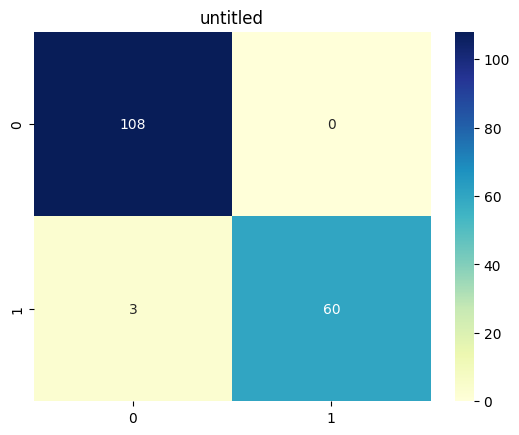

In [526]:
multi_class_heatmap(cross_conf_matrix)

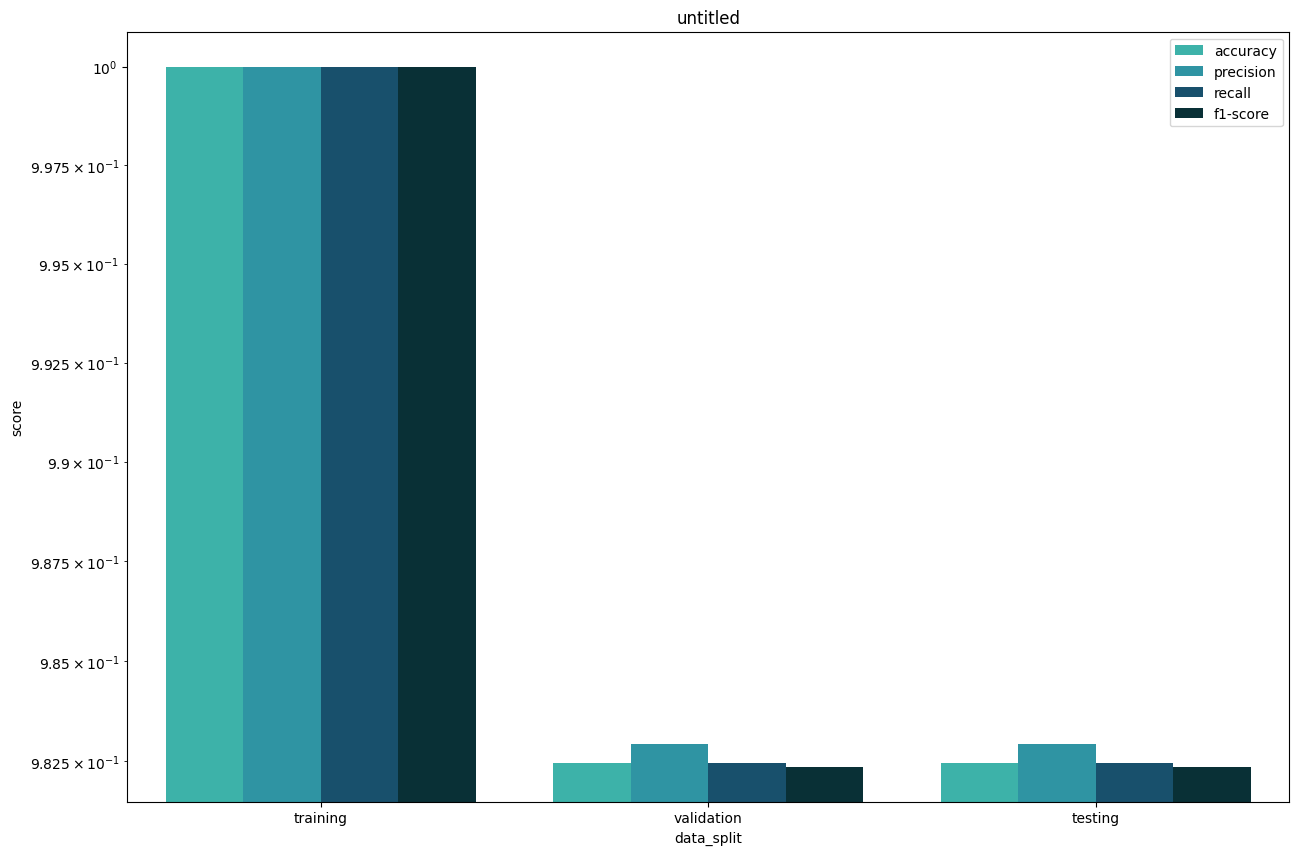

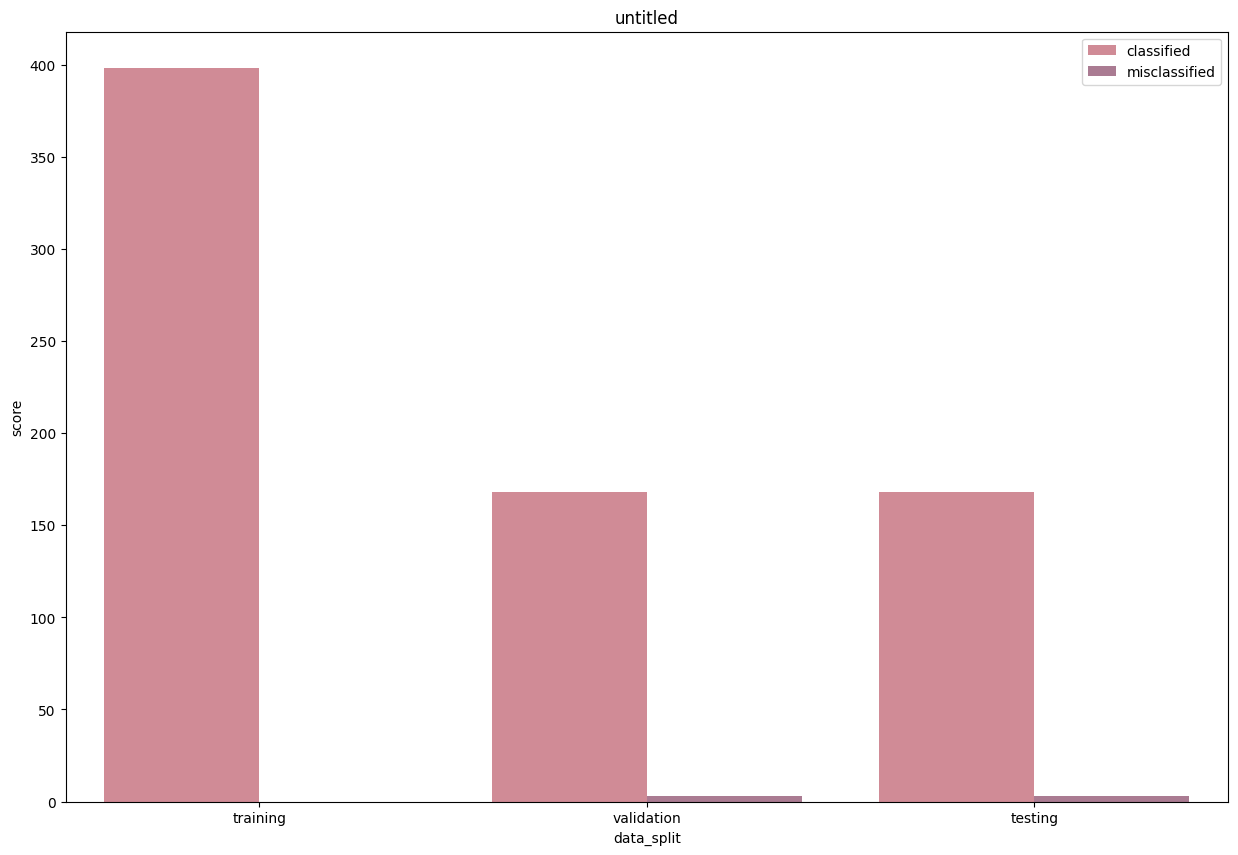

In [527]:
view_metric_values(metrics_df)
view_classified_labels(classified_df)

## Clustering

In [495]:
from utilities.visualizers import plot_evolution
from sklearn.cluster import DBSCAN, KMeans

In [496]:
# read unlabeled data
df = pd.read_csv('./data/E-commerce.csv')

# drop ID and profile information column column
df.drop(columns=['ID', 'profile_information'], inplace=True)
X = df.to_numpy()
K = 3
epochs = 300

In [497]:
df

n_clicks  n_visits  amount_spent  amount_discount  \
0          643       142        300.00           228.43   
1          527        95        743.83            60.88   
2          367        49        305.67            72.96   
3          466        30        291.19           101.90   
4          715       169        703.14           506.42   
...        ...       ...           ...              ...   
2495       231       165       3328.63           148.31   
2496       241        26       1985.95             5.13   
2497       561        85        936.92           146.64   
2498       347        61        404.91           119.28   
2499       823       160       1433.68          1138.22   

      days_since_registration  
0                         132  
1                          86  
2                         334  
3                         131  
4                         114  
...                       ...  
2495                      157  
2496                      220  
2497                       96  
2498                      194  
2499                      271  

[2500 rows x 5 columns]

In [498]:
X.shape

(2500, 5)

In [499]:
k_means = KMeans(n_clusters=K, max_iter=1, random_state=0)
k_means.fit(X)
print(k_means.cluster_centers_)

[[ 399.47145062   92.54398148  630.40939562  158.83583325  201.83256173]
 [ 254.91592129   69.28980322 3293.85964483   80.55262421  196.06976744]
 [ 560.44496124  120.18449612 1479.76549666 1116.8859466   203.49767442]]


In [500]:
k_means = KMeans(n_clusters=K, max_iter=2, random_state=0)
k_means.fit(X)
print(k_means.cluster_centers_)

[[ 406.53602941   93.63235294  650.7041783   181.17074589  202.19485294]
 [ 255.09368635   69.22403259 3461.06885549   84.57056717  198.51120163]
 [ 529.36825886  115.34668721 1584.56760092 1052.93563866  200.27734977]]


In [501]:
k_means = KMeans(n_clusters=K, max_iter=1, random_state=0)
k_means.fit(X)
print(k_means.cluster_centers_)

[[ 399.47145062   92.54398148  630.40939562  158.83583325  201.83256173]
 [ 254.91592129   69.28980322 3293.85964483   80.55262421  196.06976744]
 [ 560.44496124  120.18449612 1479.76549666 1116.8859466   203.49767442]]


In [502]:
prev_centroids = []
for epoch in range(1, 300 + 1):
    k_means = KMeans(n_clusters=K, max_iter=epoch, random_state=0)
    k_means.fit(X)
    prev_centroids.append(k_means.cluster_centers_)
prev_centroids = np.array(prev_centroids)

In [503]:
len(prev_centroids)

300

In [504]:
xs_centroids = k_means.predict(X)

In [505]:
np.unique(xs_centroids, return_counts=True)

(array([0, 1, 2]), array([ 671, 1325,  504], dtype=int64))

m: (300, 5)
centroids of cluster 0: [[ 399.47145062   92.54398148  630.40939562  158.83583325  201.83256173]
 [ 406.53602941   93.63235294  650.7041783   181.17074589  202.19485294]
 [ 405.60810811   93.44594595  637.74680614  174.53744533  201.74774775]
 ...
 [ 531.43517139  115.55439642 1553.36194956 1044.60725471  201.53204173]
 [ 531.43517139  115.55439642 1553.36194956 1044.60725471  201.53204173]
 [ 531.43517139  115.55439642 1553.36194956 1044.60725471  201.53204173]]

m: (300, 5)
centroids of cluster 1: [[ 254.91592129   69.28980322 3293.85964483   80.55262421  196.06976744]
 [ 255.09368635   69.22403259 3461.06885549   84.57056717  198.51120163]
 [ 255.07258065   69.4375     3448.92476087   84.2301466   198.22580645]
 ...
 [ 404.9645283    93.32226415  635.42273763  172.10644277  201.79471698]
 [ 404.9645283    93.32226415  635.42273763  172.10644277  201.79471698]
 [ 404.9645283    93.32226415  635.42273763  172.10644277  201.79471698]]

m: (300, 5)
centroids of cluster 2: [[

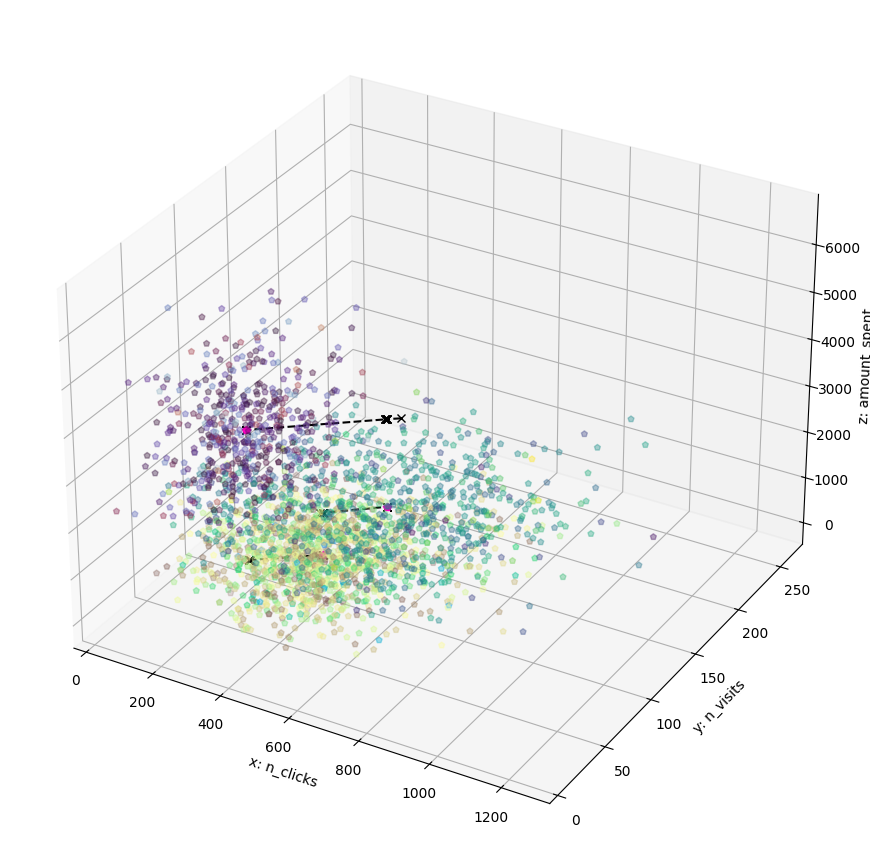

In [506]:
plot_evolution(X, K, prev_centroids, xs_centroids, features=['n_clicks', 'n_visits', 'amount_spent'], dimension='3d')

# Image Processing

In [507]:
train_gen, cross_gen, test_gen = create_image_set('./data/Micro_Organism/')

Copying files: 789 files [00:13, 57.12 files/s]

Found 549 images belonging to 8 classes.


Found 114 images belonging to 8 classes.
Found 126 images belonging to 8 classes.


In [508]:
next(train_gen)

(array([[[[0.36862746, 0.37254903, 0.37254903],
          [0.36862746, 0.37254903, 0.37254903],
          [0.36862746, 0.37254903, 0.37254903],
          ...,
          [0.36862746, 0.37254903, 0.38431376],
          [0.36862746, 0.37254903, 0.38823533],
          [0.36862746, 0.37647063, 0.38431376]],
 
         [[0.36862746, 0.37254903, 0.37254903],
          [0.36862746, 0.37254903, 0.37254903],
          [0.36862746, 0.37254903, 0.37254903],
          ...,
          [0.36862746, 0.37254903, 0.38431376],
          [0.36862746, 0.37254903, 0.38823533],
          [0.36862746, 0.37647063, 0.38431376]],
 
         [[0.36862746, 0.37647063, 0.37254903],
          [0.36862746, 0.37647063, 0.37254903],
          [0.36862746, 0.37647063, 0.37254903],
          ...,
          [0.36862746, 0.37254903, 0.38431376],
          [0.36862746, 0.37254903, 0.38823533],
          [0.36862746, 0.37647063, 0.38431376]],
 
         ...,
 
         [[0.37647063, 0.37254903, 0.40000004],
          [0.37254

In [509]:
next(cross_gen)

(array([[[[0.24313727, 0.39607847, 0.4039216 ],
          [0.2509804 , 0.40784317, 0.41176474],
          [0.24313727, 0.40000004, 0.41176474],
          ...,
          [0.2509804 , 0.4156863 , 0.4156863 ],
          [0.2509804 , 0.4156863 , 0.4156863 ],
          [0.2509804 , 0.41960788, 0.4156863 ]],
 
         [[0.24313727, 0.39607847, 0.4039216 ],
          [0.2509804 , 0.4039216 , 0.41176474],
          [0.24313727, 0.40000004, 0.41176474],
          ...,
          [0.25490198, 0.4156863 , 0.4156863 ],
          [0.25490198, 0.4156863 , 0.4156863 ],
          [0.25490198, 0.4156863 , 0.4156863 ]],
 
         [[0.2392157 , 0.40000004, 0.4039216 ],
          [0.2509804 , 0.4039216 , 0.40784317],
          [0.24705884, 0.4039216 , 0.41176474],
          ...,
          [0.2509804 , 0.41960788, 0.4156863 ],
          [0.2509804 , 0.41960788, 0.4156863 ],
          [0.2509804 , 0.41960788, 0.41960788]],
 
         ...,
 
         [[0.18431373, 0.37647063, 0.39607847],
          [0.18431

In [510]:
train_gen.class_indices

{'Amoeba': 0,
 'Euglena': 1,
 'Hydra': 2,
 'Paramecium': 3,
 'Rod_bacteria': 4,
 'Spherical_bacteria': 5,
 'Spiral_bacteria': 6,
 'Yeast': 7}

In [511]:
list(train_gen.class_indices.keys())

['Amoeba',
 'Euglena',
 'Hydra',
 'Paramecium',
 'Rod_bacteria',
 'Spherical_bacteria',
 'Spiral_bacteria',
 'Yeast']

In [512]:
images, labels = next(train_gen)

In [513]:
images[0]

array([[[0.09019608, 0.11764707, 0.12156864],
        [0.09019608, 0.11764707, 0.12156864],
        [0.08627451, 0.1137255 , 0.11764707],
        ...,
        [0.07058824, 0.08627451, 0.09019608],
        [0.07058824, 0.08627451, 0.09019608],
        [0.07058824, 0.08627451, 0.09019608]],

       [[0.09019608, 0.11764707, 0.12156864],
        [0.09019608, 0.11764707, 0.12156864],
        [0.08627451, 0.1137255 , 0.11764707],
        ...,
        [0.07058824, 0.08627451, 0.09019608],
        [0.07058824, 0.08627451, 0.09019608],
        [0.07058824, 0.08627451, 0.09019608]],

       [[0.09019608, 0.11764707, 0.12156864],
        [0.09019608, 0.11764707, 0.12156864],
        [0.08627451, 0.1137255 , 0.11764707],
        ...,
        [0.07058824, 0.08627451, 0.09019608],
        [0.07058824, 0.08627451, 0.09019608],
        [0.07058824, 0.08627451, 0.09019608]],

       ...,

       [[0.06666667, 0.09019608, 0.09411766],
        [0.06666667, 0.09019608, 0.09411766],
        [0.06666667, 0

In [514]:
labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [515]:
images.shape

(128, 256, 256, 3)

In [516]:
len(train_gen)

5

In [517]:
len(cross_gen)

4

In [518]:
len(test_gen)

4

#### Here our training data went from 576 samples to 640 because of data augmentation, for validation from 114 to 32 * 4 or 128, and for testing from 126 to 32 * 4 or 128

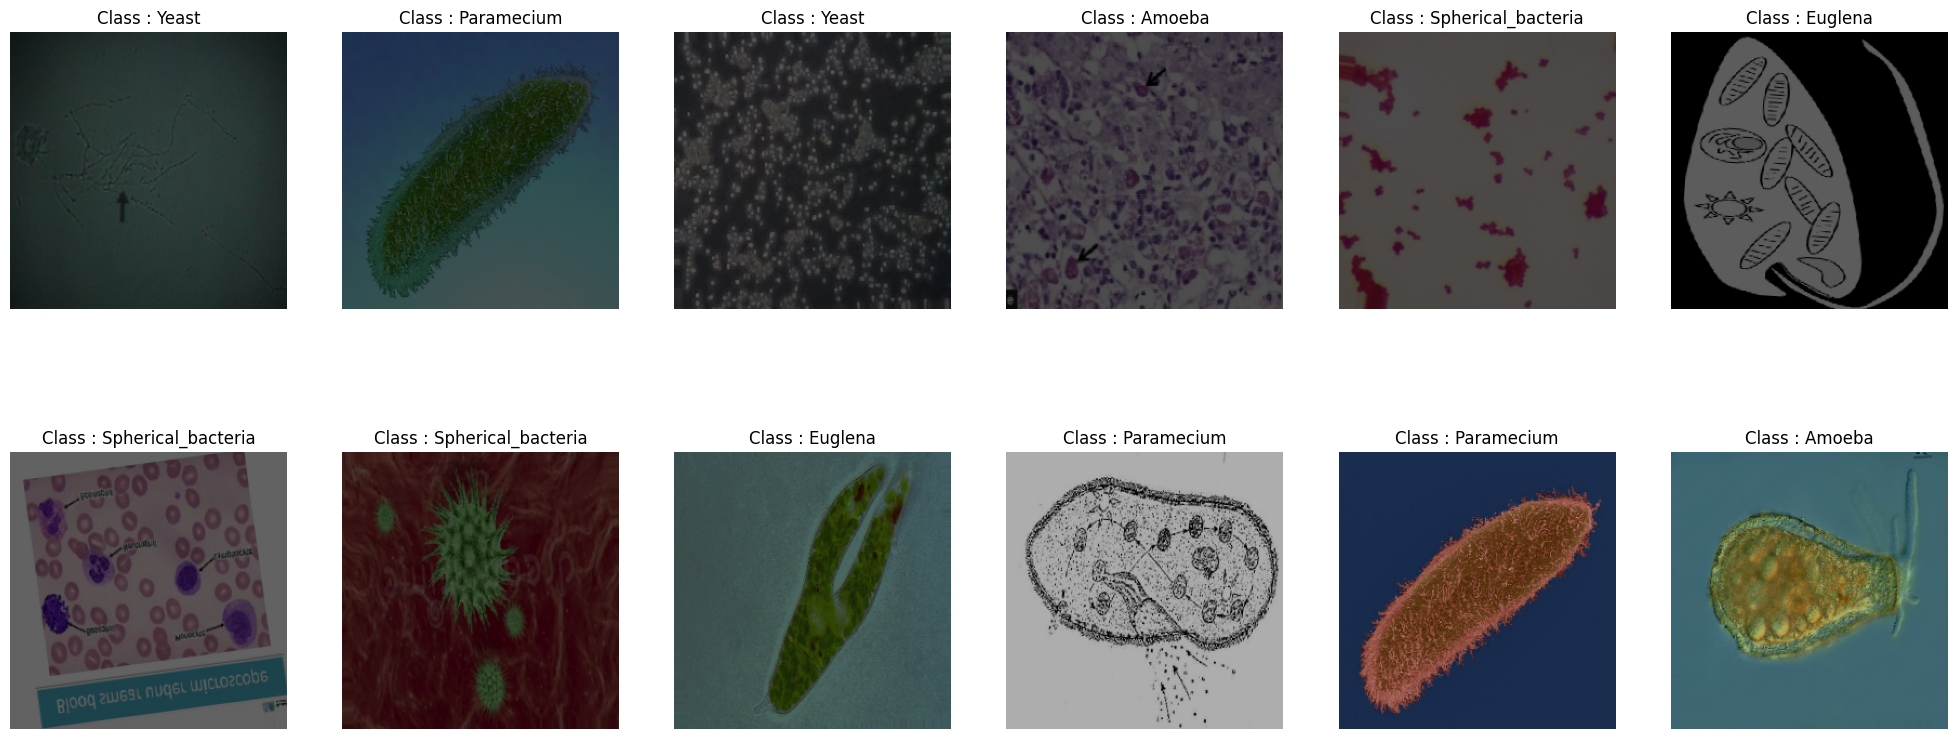

In [519]:
view_images(train_gen, save_img=False)

## NLP